# Auto Retail: How are iBuyers Affecting the Market? 
### Applying Data Science Tools to Understanding Changes in the U.S. Auto Retail & Advertising Market

    Josh Grasso | joshgrasso@gmail.com

This project seeks to provide a framework with which to answer questions that center around the key debate in the U.S. Auto Retail and Auto Advertising markets: how is the market changing with the presence of new-entrants. The data used in this analysis is produced internally through web scraping of auto inventory marketplaces: Cars.com and TrueCar as well as traditional, publicly listed dealer networks: Sonic and Lithia. 

The two main questions answered in this analysis are: 
* Are the new-entrants into auto retailing (the iBuyers) increasing the market size of auto advertising?
* Are dealer inventory volumes and/or advertising intensity changing (declining) due to the new-entrant? 


In [17]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')  #sns.set()
import matplotlib.dates as mdates

import requests, bs4
import re

idx = pd.IndexSlice
import statsmodels.api as sm

from datetime import datetime
today = datetime.now()
month,day,year = today.month,today.day,today.year

import os
from pathlib import Path

In [2]:
home_folder = Path.home() / 'Jupyter' / 'Cars_dot_com'

In [3]:
cars_dot_com_dealer_timeline_vegas = pd.read_csv(home_folder / 'Car_Inventory_Data' / 'Cars_dot_com_Dealer_Timeline_Vegas.csv', index_col=0)
cars_dot_com_dealer_timeline_nashville = pd.read_csv(home_folder / 'Car_Inventory_Data' / 'Cars_dot_com_Dealer_Timeline_Nashville.csv', index_col=0)
cars_dot_com_dealer_timeline_portland = pd.read_csv(home_folder / 'Car_Inventory_Data' / 'Cars_dot_com_Dealer_Timeline_Portland.csv', index_col=0)
cars_dot_com_dealer_timeline_tampa = pd.read_csv(home_folder / 'Car_Inventory_Data' / 'Cars_dot_com_Dealer_Timeline_Tampa.csv', index_col=0)
cars_dot_com_dealer_timeline_orlando = pd.read_csv(home_folder / 'Car_Inventory_Data' / 'Cars_dot_com_Dealer_Timeline_Orlando.csv', index_col=0)


In [4]:
# cars_dot_com_dealer_timeline_vegas
# cars_dot_com_dealer_timeline_nashville
# cars_dot_com_dealer_timeline_portland
# cars_dot_com_dealer_timeline_tampa
# cars_dot_com_dealer_timeline_orlando

In [5]:
# Parse DateTime Columns:
def parse_datetime_column_names(df):
    columns_ignore = ['Dealership','City','State','Address']
    datetime_column_names = []
    for column in df.columns: 
        if column in columns_ignore:
            datetime_column_names.append(column)
        else:
            datetime_column_names.append(pd.to_datetime(column))
    df.columns = datetime_column_names
    return df

cars_dot_com_dealer_timeline_vegas = parse_datetime_column_names(cars_dot_com_dealer_timeline_vegas)
cars_dot_com_dealer_timeline_nashville = parse_datetime_column_names(cars_dot_com_dealer_timeline_nashville)
cars_dot_com_dealer_timeline_portland = parse_datetime_column_names(cars_dot_com_dealer_timeline_portland)
cars_dot_com_dealer_timeline_tampa = parse_datetime_column_names(cars_dot_com_dealer_timeline_tampa)
cars_dot_com_dealer_timeline_orlando = parse_datetime_column_names(cars_dot_com_dealer_timeline_orlando)


In [6]:
# cars_dot_com_dealer_timeline_tampa = parse_datetime_column_names(cars_dot_com_dealer_timeline_tampa)
# cars_dot_com_dealer_timeline_orlando = parse_datetime_column_names(cars_dot_com_dealer_timeline_orlando)

In [7]:
# Select Target Dealership Networks to Analyse
ibuyer_list = ['Carvana', 'Vroom', 'Shift']

def parse_market_share(df):
    vroom_series = (df[df['Dealership'].str.lower().str.find('vroom') != -1]
                    .drop(columns=['Dealership','City','State','Address']).sum().rename('Vroom'))
    carvana_series = (df[df['Dealership'].str.lower().str.find('carvana') != -1]
                      .drop(columns=['Dealership','City','State','Address']).sum().rename('Carvana'))
    shift_series = (df[df['Dealership'].str.lower().str.find('shift') != -1]
                    .drop(columns=['Dealership','City','State','Address']).sum().rename('Shift'))
    car_max_series = (df[df['Dealership'].str.lower().str.find('carmax') != -1]
                      .drop(columns=['Dealership','City','State','Address']).sum().rename('CarMax'))
    auto_nation_series = (df[df['Dealership'].str.lower().str.find('autonation') != -1]
                          .drop(columns=['Dealership','City','State','Address']).sum().rename('AutoNation'))
    tred_series = (df[df['Dealership'].str.lower().str.find('tred') != -1]
                          .drop(columns=['Dealership','City','State','Address']).sum().rename('TRED'))    
    carlotz_series = (df[df['Dealership'].str.lower().str.find('carlotz') != -1]
                          .drop(columns=['Dealership','City','State','Address']).sum().rename('CarLotz'))    
    total_series = (df.drop(columns=['Dealership','City','State','Address']).sum().rename('Total'))

    market_share_df = (total_series.to_frame().join(carvana_series).join(vroom_series).join(shift_series)
                       .join(car_max_series).join(auto_nation_series)
                       .join(tred_series).join(carlotz_series))
    return market_share_df

In [8]:
# Parse Dealer Market Shares:
market_share_vegas_df = parse_market_share(cars_dot_com_dealer_timeline_vegas)
market_share_nashville_df = parse_market_share(cars_dot_com_dealer_timeline_nashville)
market_share_portland_df = parse_market_share(cars_dot_com_dealer_timeline_portland)
market_share_tampa_df = parse_market_share(cars_dot_com_dealer_timeline_tampa)
market_share_orlando_df = parse_market_share(cars_dot_com_dealer_timeline_orlando)

In [9]:
# market_share_portland_df
# market_share_orlando_df

In [10]:
def to_market_percentage(df):
    return (df.drop(columns='Total').div(df['Total'], axis=0).apply(lambda x: round(x*100, 1)))

percentage_market_share_vegas_df = to_market_percentage(market_share_vegas_df)
percentage_market_share_nashville_df = to_market_percentage(market_share_nashville_df)
percentage_market_share_portland_df = to_market_percentage(market_share_portland_df)
percentage_market_share_tampa_df = to_market_percentage(market_share_tampa_df)
percentage_market_share_orlando_df = to_market_percentage(market_share_orlando_df)

In [11]:
# Plots: Dealer and iBuyer share of Cars.com listing inventory (accross 5 markets)
# Linear Time: 
# Acutal Market Share and Change in Market Share 

In [12]:
# Vegas: 
percentage_market_share_vegas_df  #.columns

,Carvana,Vroom,Shift,CarMax,AutoNation,TRED,CarLotz
2021-05-26,13.6,7.0,0.0,10.6,3.2,0.0,0.0
2021-05-27,14.8,7.1,0.0,10.8,2.7,0.0,0.0
2021-05-28,16.1,7.6,0.0,8.0,3.3,0.0,0.0
2021-06-01,11.3,12.9,0.0,5.1,14.8,0.0,0.0
2021-06-04,11.1,11.5,0.0,6.7,13.9,0.0,0.0
2021-06-09,8.5,11.7,0.0,6.8,13.9,0.0,0.0
2021-06-14,9.3,11.7,0.0,7.1,13.1,0.0,0.0


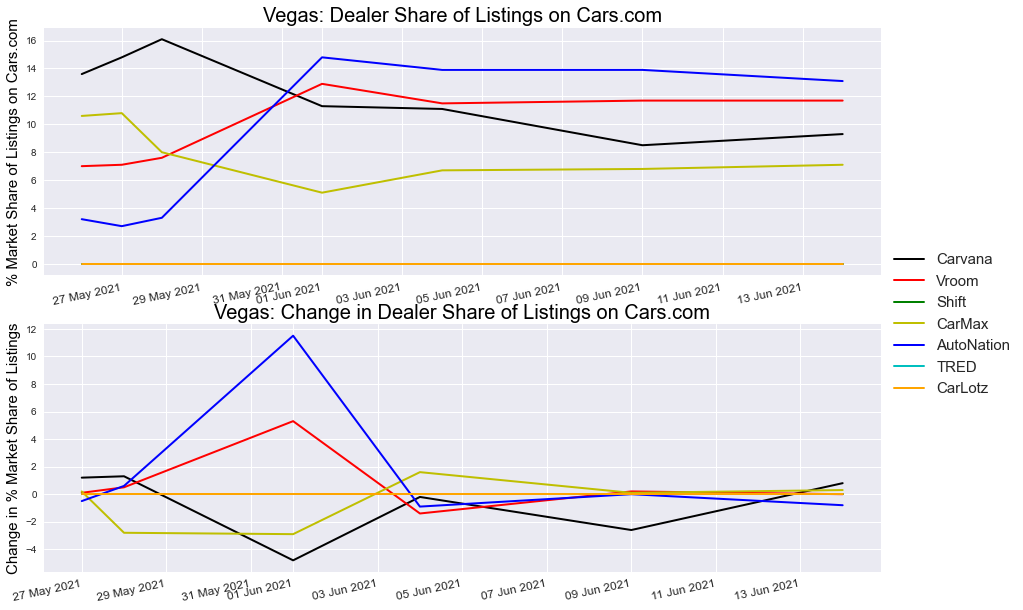

In [23]:
df = percentage_market_share_vegas_df
df.index = pd.to_datetime(df.index)
_city = 'Vegas' 

color_dict = {'Carvana': u'k', 'Vroom': u'r', 'Shift': u'g', 'CarMax': u'y', 'AutoNation': u'b', 
              'TRED': u'c', 'CarLotz': 'orange'}
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(15, 10));
for column in df.columns:
    ax1.plot(df[column], color=color_dict[column], linewidth=2);
    ax2.plot(df.diff()[column], color=color_dict[column], linewidth=2);
ax1.set_ylabel('% Market Share of Listings on Cars.com', color=u'k', fontsize=15)
ax1.set_title(f'{_city}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax1.get_xticklabels(), rotation=12, ha="right", fontsize=12)


ax2.set_ylabel('Change in % Market Share of Listings', color=u'k', fontsize=15)
ax2.set_title(f'{_city}: Change in Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(1.0,1), loc="center left", fontsize=15)
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax2.get_xticklabels(), rotation=12, ha="right", fontsize=12)

# plt.savefig(home_folder / 'Figures' / "Figure_ ... .png")
plt.show()


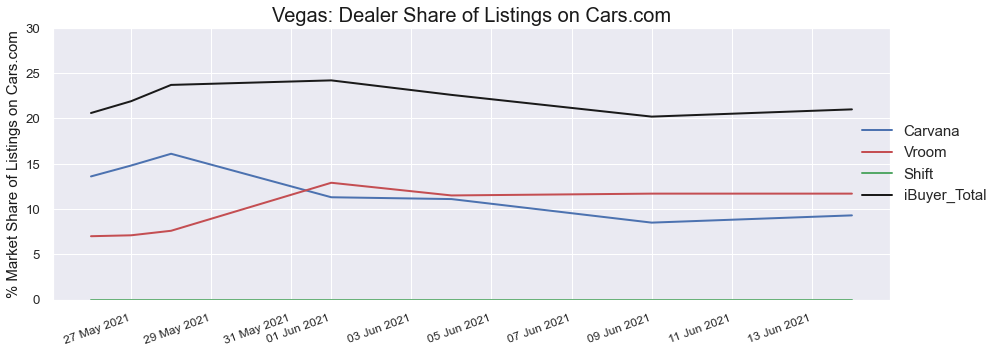

In [122]:
# iBuyer-only
df = percentage_market_share_vegas_df[ibuyer_list]
_city = 'Vegas' 

df = df.assign(iBuyer_Total = df.sum(axis=1).values)
df.index = pd.to_datetime(df.index)
color_dict = {'iBuyer_Total': u'k', 'Carvana': u'b', 'Vroom': u'r', 'Shift': u'g'}
fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.plot(df[column], color=color_dict[column], linewidth=2);
ax.set_ylabel('% Market Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_city}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,30)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_iBuyer_Vegas.png")
plt.show()


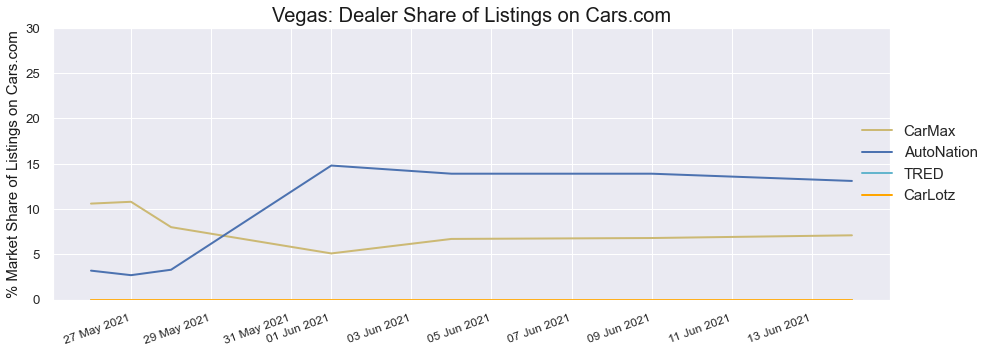

In [123]:
# Dealerships & Others
df = percentage_market_share_vegas_df.drop(columns=ibuyer_list)
df.index = pd.to_datetime(df.index)
_city = 'Vegas' 

color_dict = {'Carvana': u'k', 'Vroom': u'r', 'Shift': u'g', 'CarMax': u'y', 'AutoNation': u'b', 
              'TRED': u'c', 'CarLotz': 'orange'}
fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.plot(df[column], color=color_dict[column], linewidth=2);
ax.set_ylabel('% Market Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_city}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,30)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_Traditional_Vegas.png")
plt.show()

In [16]:
# Nashville: 
percentage_market_share_nashville_df

,Carvana,Vroom,Shift,CarMax,AutoNation,TRED,CarLotz
2021-05-26,9.5,4.8,0.0,6.2,0.0,0.0,0.0
2021-05-28,13.1,10.0,0.0,4.8,0.0,0.0,0.0
2021-05-29,7.4,8.5,0.0,6.6,0.0,0.0,0.7
2021-06-01,6.7,9.5,0.0,6.2,0.0,0.0,0.6
2021-06-04,10.0,9.6,0.0,6.8,0.0,0.0,0.4
2021-06-09,9.5,9.3,0.0,5.3,0.0,0.0,0.5
2021-06-14,9.7,9.6,0.0,4.9,0.0,0.0,0.5


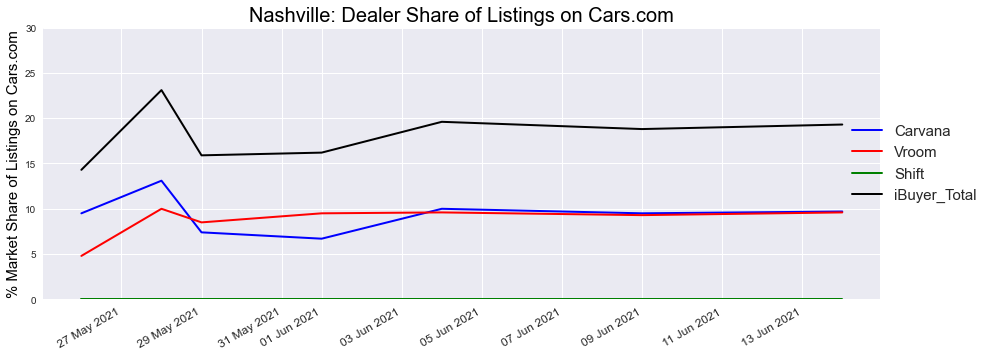

In [31]:
# iBuyer-only
df = percentage_market_share_nashville_df[ibuyer_list]
_city = 'Nashville'

df = df.assign(iBuyer_Total = df.sum(axis=1).values)
df.index = pd.to_datetime(df.index)
color_dict = {'iBuyer_Total': u'k', 'Carvana': u'b', 'Vroom': u'r', 'Shift': u'g'}
fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.plot(df[column], color=color_dict[column], linewidth=2);
ax.set_ylabel('% Market Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_city}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,30)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_iBuyer_Nashville.png")
plt.show()


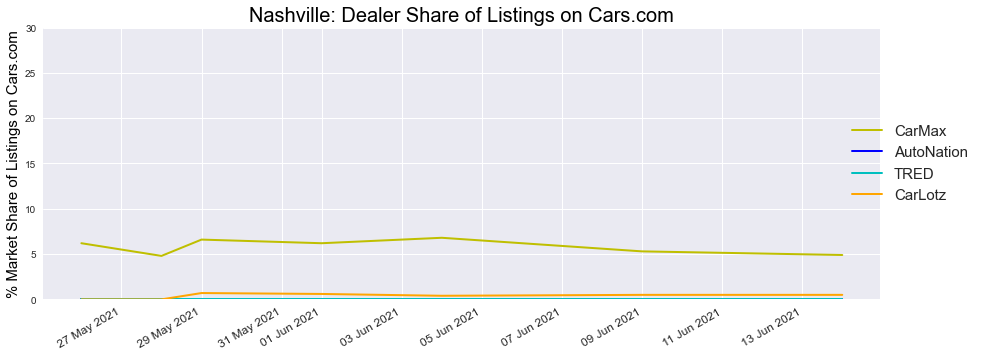

In [33]:
# Dealerships & Others
df = percentage_market_share_nashville_df.drop(columns=ibuyer_list)
df.index = pd.to_datetime(df.index)
_city = 'Nashville'

color_dict = {'Carvana': u'k', 'Vroom': u'r', 'Shift': u'g', 'CarMax': u'y', 'AutoNation': u'b', 
              'TRED': u'c', 'CarLotz': 'orange'}
fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.plot(df[column], color=color_dict[column], linewidth=2);
ax.set_ylabel('% Market Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_city}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,30)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_Traditional_Nashville.png")
plt.show()


In [19]:
# Portland: 
percentage_market_share_portland_df

,Carvana,Vroom,Shift,CarMax,AutoNation,TRED,CarLotz
2021-05-26,11.7,4.0,3.3,4.1,0.0,0.0,0.0
2021-05-28,14.8,4.0,3.7,5.4,0.0,0.0,0.0
2021-05-29,8.0,6.3,3.5,4.7,0.0,1.4,0.0
2021-06-01,7.7,6.9,3.7,4.9,0.0,1.6,0.0
2021-06-02,10.2,7.4,3.7,4.6,0.0,1.3,0.0
2021-06-04,11.1,7.4,3.8,5.0,0.0,1.3,0.0
2021-06-09,10.4,7.1,3.9,4.7,0.0,1.1,0.0
2021-06-14,8.5,7.1,3.6,4.2,0.0,1.1,0.0


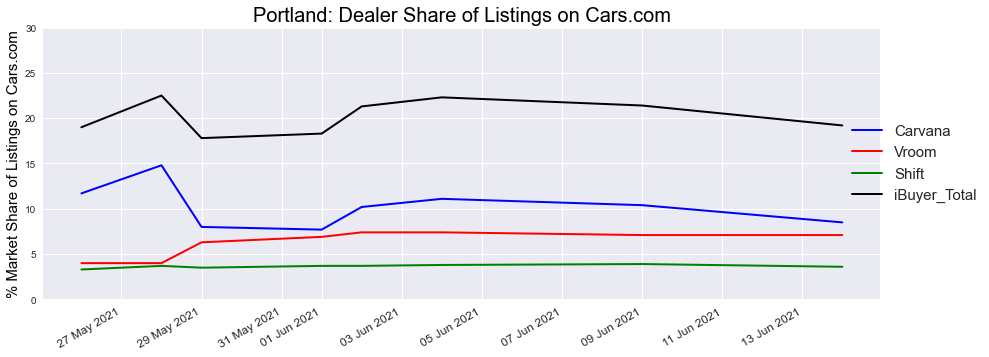

In [35]:
# iBuyer-only
df = percentage_market_share_portland_df[ibuyer_list]
_city = 'Portland'

df = df.assign(iBuyer_Total = df.sum(axis=1).values)
df.index = pd.to_datetime(df.index)
color_dict = {'iBuyer_Total': u'k', 'Carvana': u'b', 'Vroom': u'r', 'Shift': u'g'}
fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.plot(df[column], color=color_dict[column], linewidth=2);
ax.set_ylabel('% Market Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_city}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,30)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_iBuyer_Portland.png")
plt.show()


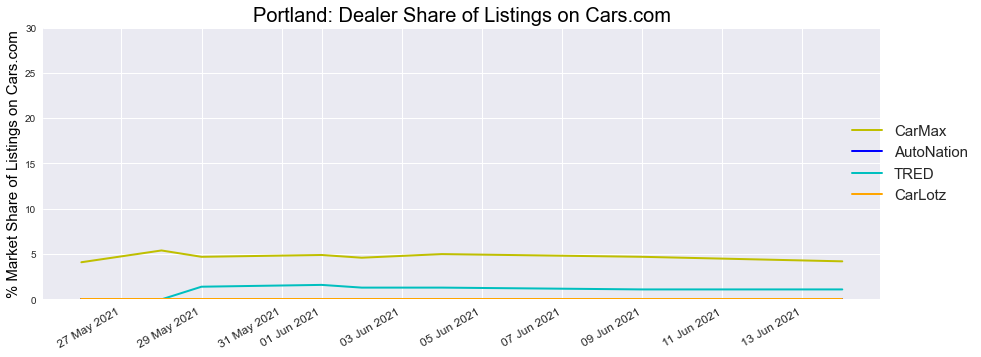

In [37]:
# Dealerships & Others
df = percentage_market_share_portland_df.drop(columns=ibuyer_list)
df.index = pd.to_datetime(df.index)
_city = 'Portland'

color_dict = {'Carvana': u'k', 'Vroom': u'r', 'Shift': u'g', 'CarMax': u'y', 'AutoNation': u'b', 
              'TRED': u'c', 'CarLotz': 'orange'}
fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.plot(df[column], color=color_dict[column], linewidth=2);
ax.set_ylabel('% Market Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_city}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,30)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_Traditional_Portland.png")
plt.show()


In [38]:
# percentage_market_share_tampa_df
# percentage_market_share_orlando_df

In [39]:
def unstack_cars_mkt_share(df, market_str):
    df = (df.unstack().to_frame().reset_index()
          .rename(columns={'level_0': 'Dealer','level_1': 'Date', 0: 'Market_Share'}))
    df = df.assign(Market = market_str)
    return df

market_share_database = pd.DataFrame()
market_share_database = market_share_database.append(unstack_cars_mkt_share(percentage_market_share_vegas_df, 'Vegas'))
market_share_database = market_share_database.append(unstack_cars_mkt_share(percentage_market_share_nashville_df, 'Nashville'))
market_share_database = market_share_database.append(unstack_cars_mkt_share(percentage_market_share_portland_df, 'Portland'))
market_share_database = market_share_database.append(unstack_cars_mkt_share(percentage_market_share_tampa_df, 'Tampa'))
market_share_database = market_share_database.append(unstack_cars_mkt_share(percentage_market_share_orlando_df, 'Orlando'))


In [40]:
market_share_database

,Dealer,Date,Market_Share,Market
0,Carvana,2021-05-26,13.6,Vegas
1,Carvana,2021-05-27,14.8,Vegas
2,Carvana,2021-05-28,16.1,Vegas
3,Carvana,2021-06-01,11.3,Vegas
4,Carvana,2021-06-04,11.1,Vegas
...,...,...,...,...
23,TRED,2021-06-14,0.0,Orlando
24,CarLotz,2021-06-01,0.0,Orlando
25,CarLotz,2021-06-04,0.0,Orlando
26,CarLotz,2021-06-09,0.0,Orlando


In [124]:
# iBuyer Total Mkt Share:

ibuyer_df = market_share_database.pivot(index='Date', columns=['Market', 'Dealer'], values='Market_Share')
idx = pd.IndexSlice
for mkt in ibuyer_df.columns.get_level_values('Market').unique():
    _df = ibuyer_df.loc[:, idx[mkt, ibuyer_list]] 
    index = pd.MultiIndex.from_tuples([(mkt, 'iBuyer_Total')], names=['Market', 'Dealer'])
    ibuyer_df = ibuyer_df.join(pd.DataFrame(_df.sum(axis=1), columns=index))


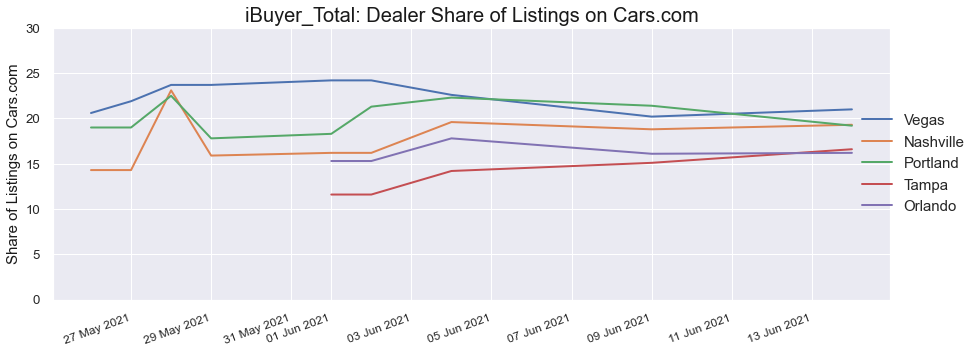

In [125]:
_dealer = 'iBuyer_Total'
df = ibuyer_df.loc[:, idx[:, _dealer]].droplevel('Dealer', axis=1).replace(0.0, np.nan).ffill()  

fig, ax = plt.subplots(figsize=(15, 5));
ax.plot(df, linewidth=2); 
ax.set_ylabel('Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_dealer}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,30)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_iBuyer_AllMkts.png")
plt.show()


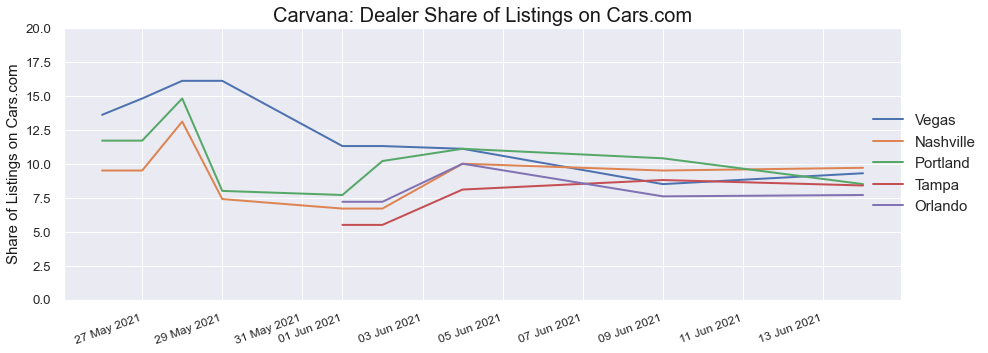

In [126]:
_dealer = 'Carvana'
df = ibuyer_df.loc[:, idx[:, _dealer]].droplevel('Dealer', axis=1).replace(0.0, np.nan).ffill()  

fig, ax = plt.subplots(figsize=(15, 5));
ax.plot(df, linewidth=2); 
ax.set_ylabel('Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_dealer}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,20)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_Carvana_AllMkts.png")
plt.show()


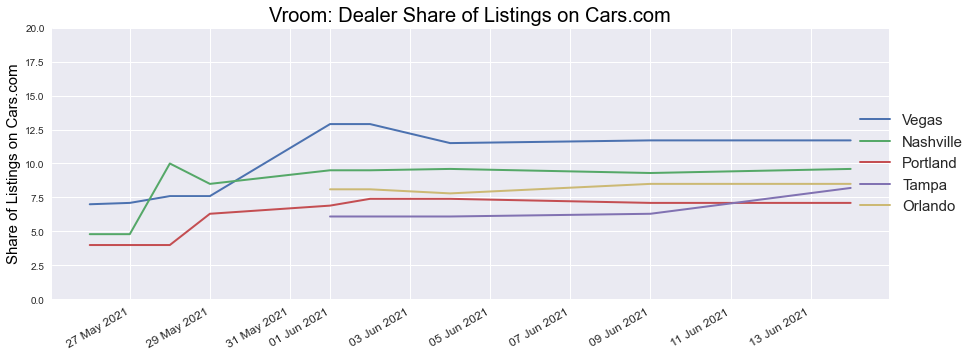

In [47]:
_dealer = 'Vroom'
df = ibuyer_df.loc[:, idx[:, _dealer]].droplevel('Dealer', axis=1).replace(0.0, np.nan).ffill()  

fig, ax = plt.subplots(figsize=(15, 5));
ax.plot(df, linewidth=2); 
ax.set_ylabel('Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_dealer}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,20)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_Vroom_AllMkts.png")
plt.show()


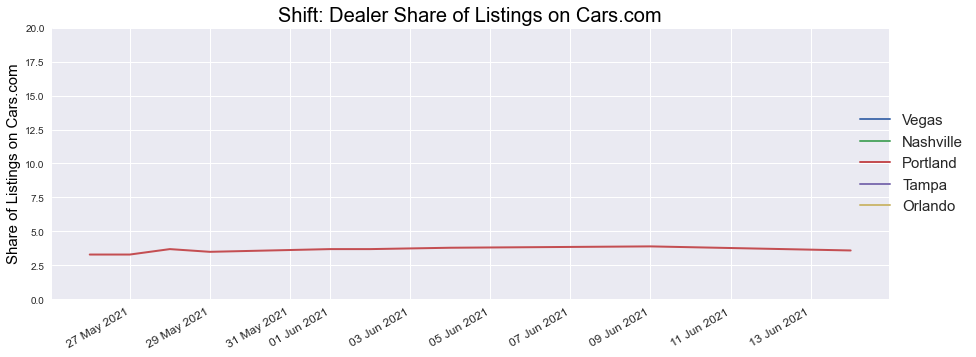

In [49]:
_dealer = 'Shift'
df = ibuyer_df.loc[:, idx[:, _dealer]].droplevel('Dealer', axis=1).replace(0.0, np.nan).ffill()  

fig, ax = plt.subplots(figsize=(15, 5));
ax.plot(df, linewidth=2); 
ax.set_ylabel('Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_dealer}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,20)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_Shift_AllMkts.png")
plt.show()


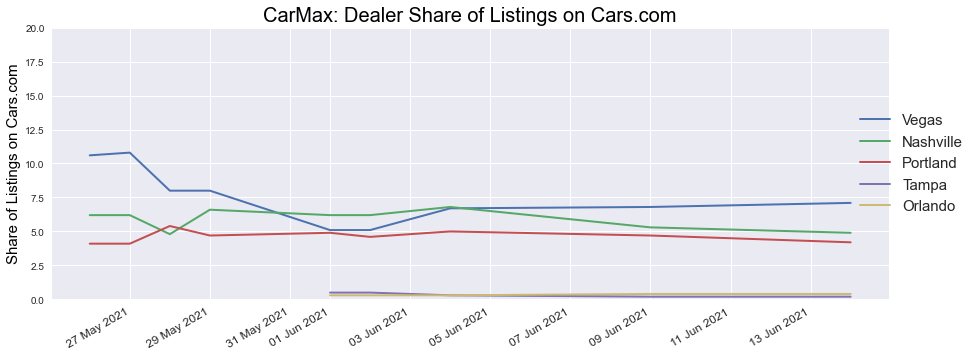

In [51]:
_dealer = 'CarMax'
df = ibuyer_df.loc[:, idx[:, _dealer]].droplevel('Dealer', axis=1).replace(0.0, np.nan).ffill()  

fig, ax = plt.subplots(figsize=(15, 5));
ax.plot(df, linewidth=2); 
ax.set_ylabel('Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_dealer}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,20)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_CarMax_AllMkts.png")
plt.show()


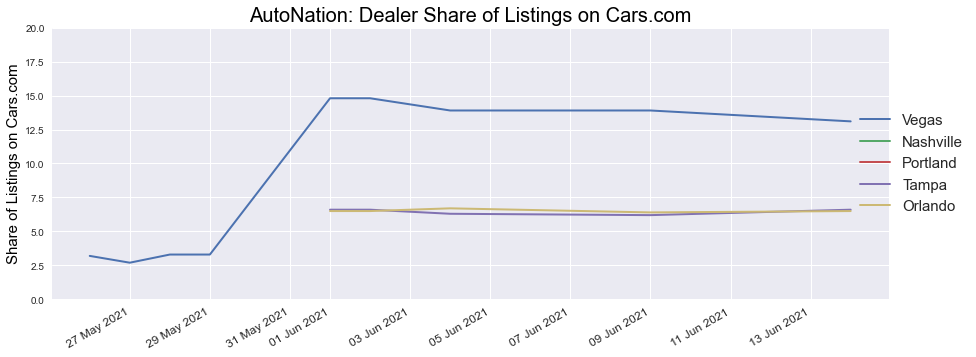

In [53]:
_dealer = 'AutoNation'
df = ibuyer_df.loc[:, idx[:, _dealer]].droplevel('Dealer', axis=1).replace(0.0, np.nan).ffill()  

fig, ax = plt.subplots(figsize=(15, 5));
ax.plot(df, linewidth=2); 
ax.set_ylabel('Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_dealer}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,20)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_AutoNation_AllMkts.png")
plt.show()


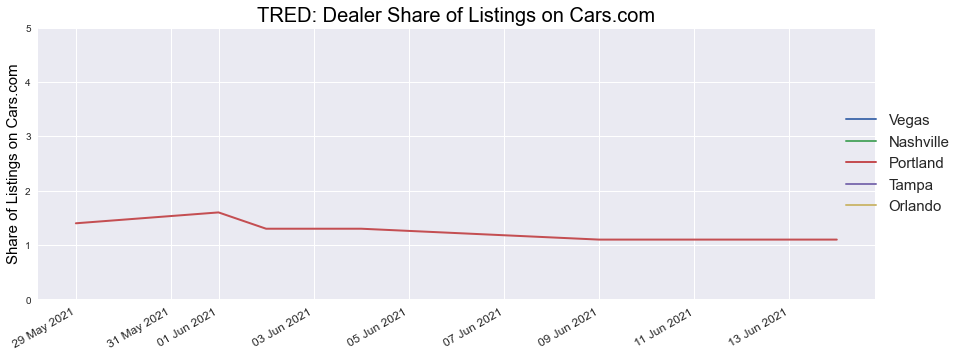

In [55]:
_dealer = 'TRED'
df = ibuyer_df.loc[:, idx[:, _dealer]].droplevel('Dealer', axis=1).replace(0.0, np.nan).ffill()  

fig, ax = plt.subplots(figsize=(15, 5));
ax.plot(df, linewidth=2); 
ax.set_ylabel('Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_dealer}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,5)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_TRED_AllMkts.png")
plt.show()


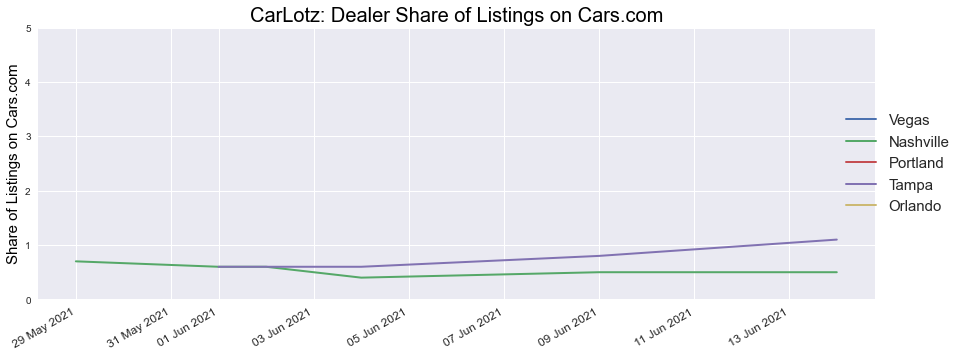

In [57]:
_dealer = 'CarLotz'
df = ibuyer_df.loc[:, idx[:, _dealer]].droplevel('Dealer', axis=1).replace(0.0, np.nan).ffill()  

fig, ax = plt.subplots(figsize=(15, 5));
ax.plot(df, linewidth=2); 
ax.set_ylabel('Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_title(f'{_dealer}: Dealer Share of Listings on Cars.com', color=u'k', fontsize=20)    
plt.legend(df.columns, bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)
ax.set_ylim(0,5)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_CarLotz_AllMkts.png")
plt.show()


In [58]:
# Top Two Traditional and iBuyer Dealers:

top_two_dealers_df = market_share_database.pivot(index='Date', columns=['Market', 'Dealer'], 
                                                 values='Market_Share')
for mkt in top_two_dealers_df.columns.get_level_values('Market').unique():
    _df = top_two_dealers_df.loc[:, idx[mkt, ['Carvana', 'Vroom']]]
    index = pd.MultiIndex.from_tuples([(mkt, 'Top_iBuyers')], names=['Market', 'Dealer'])
    top_two_dealers_df = top_two_dealers_df.join(pd.DataFrame(_df.sum(axis=1), columns=index))
    
    _df = top_two_dealers_df.loc[:, idx[mkt, ['CarMax', 'AutoNation']]]
    index = pd.MultiIndex.from_tuples([(mkt, 'Top_Dealers')], names=['Market', 'Dealer'])
    top_two_dealers_df = top_two_dealers_df.join(pd.DataFrame(_df.sum(axis=1), columns=index))
top_two_dealers_df = (top_two_dealers_df.loc[:, idx[:, ['Top_iBuyers', 'Top_Dealers']]]
                      .unstack().to_frame().rename(columns={0:'Mkt_Share'}).reset_index())


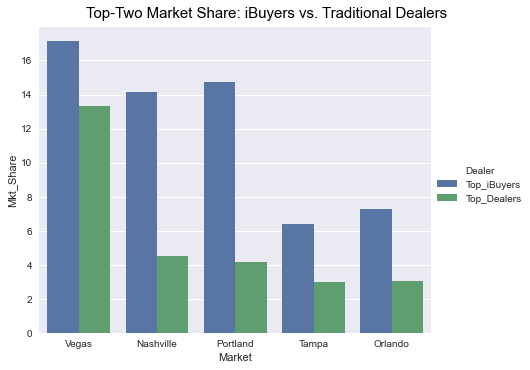

In [59]:
f = sns.catplot(data=top_two_dealers_df, x = 'Market', y='Mkt_Share', hue = 'Dealer', kind='bar', 
                ci=None, aspect=12/10)
f.fig.subplots_adjust(top=0.925) # adjust the Figure in rp
f.fig.suptitle('Top-Two Market Share: iBuyers vs. Traditional Dealers', color=u'k', fontsize=15)
plt.savefig(home_folder / 'Figures' / "Figure_Top_iBuyer_vs_Traditional_AllMkts.png")
plt.show()

In [60]:
# Plots: Dealer and iBuyer share of Cars.com listing inventory (accross 5 markets)
# 'Carvana Time': 


In [61]:
# Build Indexes for each Market: 

# Let's analyze each market from the perspective of the elapsed time since Carvana launched,
# to get a perspective on growth in market share on Cars.com since launch date 

# Carvana Market Details:
# Source: 'https://investors.carvana.com/~/media/Files/C/Carvana-IR/investor-materials/carvana-market-launches-population-estimates-and-irc-capacity-05192021.xlsx'

carvana_market_details_df = pd.read_excel(home_folder / 'Car_Inventory_Data' / 'Carvana_Market_Details.xlsx', sheet_name='Market Data', header=1)  # index_col=0 
carvana_market_details_df = carvana_market_details_df[carvana_market_details_df['Market'].notna()]

carvana_market_details_df.sort_values(by='Estimated Annual Used Vehicle Sales(1)', ascending=False).reset_index(drop=True).head(10)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,No.,Starting Year,Market,Market Launch Date,Market Population(x),Estimated Annual Used Vehicle Sales(1),Pickup Option,Pickup Option Launch Date,Unnamed: 8
0,38,2017,"Los Angeles / Riverside, CA(2)",2017-09-06,17829227.0,2.123192e+06,Vending Machines,8/15/2019 (7) \n9/6/2019 (7),NaN
1,25,2017,"Chicago, IL",2017-05-10,9551031.0,1.137384e+06,Vending Machine,2019-04-10 00:00:00,NaN
2,64,2018,"New York City, NY(4)",2018-06-27,8550405.0,1.018224e+06,NaN,NaN,NaN
3,5,2015,"Dallas, TX",2015-05-07,7102796.0,8.458360e+05,Vending Machine,2017-04-20 00:00:00,NaN
4,43,2017,"Newark, NJ(3)",2017-12-20,6694087.0,7.971649e+05,NaN,NaN,NaN
5,6,2015,"Houston, TX",2015-10-12,6656947.0,7.927421e+05,Vending Machine,2016-12-14 00:00:00,NaN
6,15,2016,"Washington, DC",2016-07-27,6097684.0,7.261423e+05,Vending Machine,2018-06-05 00:00:00,NaN
7,23,2017,"Philadelphia, PA",2017-03-22,6069875.0,7.228307e+05,Vending Machine,2018-09-26 00:00:00,NaN
8,13,2016,"Miami, FL",2016-04-11,6012331.0,7.159781e+05,Vending Machine,2020-01-29 00:00:00,NaN
9,1,2013,"Atlanta, GA",2013-01-21,5710795.0,6.800697e+05,Curbside Vending Machine,11/1/2013 (8) \n11/18/2020 (8),NaN


In [62]:
def get_carvana_launch_date(df, market):
    return df[df['Market'].str.find(market) != -1]

market_launch_dict = {'Vegas': None, 'Nashville': None, 'Portland': None, 'Tampa': None, 'Orlando': None}
vending_launch_dict = {'Vegas': None, 'Nashville': None, 'Portland': None, 'Tampa': None, 'Orlando': None}

for mkt in market_launch_dict.keys():
    market_launch_dict[mkt] = (get_carvana_launch_date(carvana_market_details_df, mkt)
                               ['Market Launch Date'].values[0])
    vending_launch_dict[mkt] = (get_carvana_launch_date(carvana_market_details_df, mkt)
                               ['Pickup Option Launch Date'].values[0])


In [63]:
# Plot Timeline: 
color_dict = {'Vegas': u'y', 'Nashville': 'orange', 'Portland': u'r', 'Tampa': u'g', 'Orlando': u'b'}

carvana_timeline_df = (pd.DataFrame.from_dict(market_launch_dict, orient='index', columns=['Market_Launch'])
                       .join(pd.DataFrame.from_dict(vending_launch_dict, orient='index', columns=['Vending_Machine'])))
carvana_timeline_df.index = carvana_timeline_df.index.rename('Market')
carvana_timeline_df = carvana_timeline_df.join(pd.DataFrame.from_dict(color_dict, orient='index', columns=['Color']))


In [64]:
# carvana_timeline_df

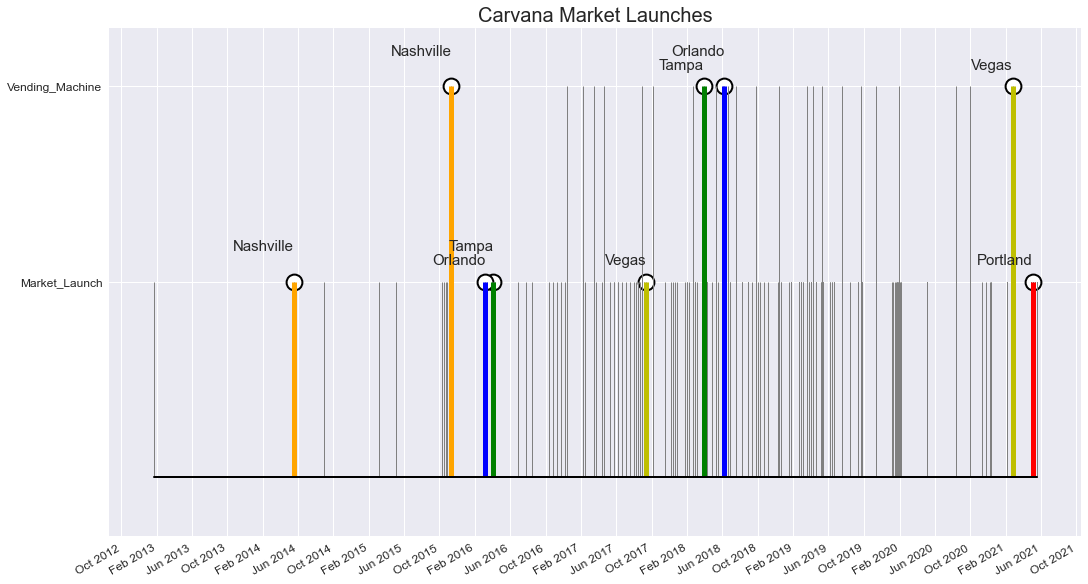

In [65]:
height_dict = {'Market_Launch': 5, 'Vending_Machine': 10}


fig, ax = plt.subplots(figsize=(15, 8), constrained_layout=True)
ax.set_title('Carvana Market Launches', fontsize=20)

all_list = pd.to_datetime(carvana_market_details_df['Market Launch Date'], errors='coerce').dropna().tolist()
ax.vlines(all_list, 0, np.ones_like(all_list, dtype='int') * 5, color='grey', linewidth=1) 
ax.plot(all_list, np.zeros_like(all_list, dtype='int'), 
        color=u'k', linewidth=2)  # Baseline
all_list = pd.to_datetime(carvana_market_details_df['Pickup Option Launch Date'], errors='coerce').dropna().tolist()
ax.vlines(all_list, 0, np.ones_like(all_list, dtype='int') * 10, color='grey', linewidth=1) 


for event in height_dict.keys():
    df = carvana_timeline_df[[event, 'Color']].dropna(how='any')
    ax.vlines(df[event], 0, np.ones_like(df[event], dtype='int') * height_dict[event], 
              color=df['Color'], linewidth=5)  # The vertical stems.
    ax.scatter(df[event], np.ones_like(df[event], dtype='int') * height_dict[event],
               s=250, c="w", marker='o', edgecolors=u'k', linewidths=2)  # Markers  "o", color=u'k', 
    _alternate = -1
    for d, l, r in zip(df[event], 
                       np.ones_like(df[event], dtype='int') * height_dict[event], 
                       df.index):
        ax.annotate(r, xy=(d, l),
                    xytext=(0, 35 + (_alternate * 7)), textcoords="offset points",
                    horizontalalignment="right",
                    verticalalignment="top",
                   fontsize=15)
        _alternate = _alternate * -1

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize=12)

ax.set_yticks([5,10])
ax.set_yticklabels(height_dict.keys(), fontsize=12)

ax.margins(y=0.15)
plt.savefig(home_folder / 'Figures' / "Figure_Carvana_Mkt_Launch_Timeline.png")
plt.show()

In [66]:
# Vending Machine launch - days since market launch? 
# Vending Machine launch - market share on cars.com?  

In [67]:
# Other Timelines:

# Shift: 
# {'Portland': datetime(2019, 4, 23),  # April 23, 2019  # https://investors.shift.com/news-releases/news-release-details/shift-experiences-major-growth-expands-new-markets

# Customers can Buy - Market: 
# {'Vegas': datetime(2021, 5, 4),  # May 4, 2021  # https://investors.shift.com/news-releases/news-release-details/shift-begins-buying-cars-consumers-las-vegas
# {'Austin': datetime(2021, 5, 10),  # May 10, 2021
# {'San_Antonio': datetime(2021, 5, 10),  # May 10, 2021
# {'Seattle': datetime(2020, 10, 28),  # October 28, 2020  # https://investors.shift.com/news-releases/news-release-details/shift-launches-newest-buyer-market-seattle

# Customers can Sell - Market:
# {'San_Antonio': datetime(2020, 11, 17),  # November 17, 2020  # https://investors.shift.com/news-releases/news-release-details/shift-announces-second-seller-market-texas
# {'Austin': datetime(2021, 11, 9), # November 09, 2020  # https://investors.shift.com/news-releases/news-release-details/shift-brings-its-car-marketplace-texas
# {'Seattle': datetime(2020, 3, 17), #  March 17, 2020  # https://investors.shift.com/news-releases/news-release-details/shift-launches-digital-car-marketplace-washington-0

# CarLotz:
# {'Nashville': datetime(2021, 3, 29),  # March 29, 2021  # https://investors.carlotz.com/news-releases/news-release-details/carlotz-nashville-now-open
# {'Seattle': datetime(2021, 2, 2),  # February 2, 2021  # https://investors.carlotz.com/news-releases/news-release-details/carlotz-enters-west-coast-market-and-opens-second-florida


In [68]:
# Build Indexes for each Market: 

def build_index(market_launch_dict, str_market):  
    # X-Axis: Date
    index = pd.date_range(start=market_launch_dict[str_market], end=datetime(year, month,day), 
                          freq='D', name='Date')  # df.index[-1]
    # X-Axis: Days Since Launch 
    days_count = np.arange(0, index.size)
    indexed_df = pd.DataFrame(days_count, index=index, columns=['Days_Since_Launch'])
    return indexed_df


In [69]:
# Carvana:
carvana_market_share = market_share_database[market_share_database['Dealer'] == 'Carvana']
timeline_carvana_market_share = pd.DataFrame()
for mkt in market_launch_dict.keys():
    index_df = build_index(market_launch_dict, mkt)
    index_df = index_df.join(carvana_market_share[carvana_market_share['Market'] == mkt].set_index('Date'),
                            how='left').reset_index().set_index('Days_Since_Launch')
    timeline_carvana_market_share = timeline_carvana_market_share.append(index_df, ignore_index=False)
timeline_carvana_market_share_unstacked = timeline_carvana_market_share.copy()

In [70]:
# carvana_market_share
# timeline_carvana_market_share.dropna()

In [71]:
timeline_carvana_market_share = (timeline_carvana_market_share.sort_index(ascending=True)
                                 .drop(columns=['Dealer', 'Date'])
                                 .dropna().reset_index()
                                 .pivot(index='Days_Since_Launch', columns='Market', values='Market_Share')) 

timeline_carvana_market_share['Average'] = timeline_carvana_market_share.mean(axis=1)

In [72]:
# Multi-leve Regression: 

# Variables:
df = (timeline_carvana_market_share_unstacked.drop(columns='Date')  # 'Dealer'
      .dropna().reset_index().sort_values('Days_Since_Launch'))

# Regression: 
multi_level_sm = sm.MixedLM.from_formula("Market_Share ~ Days_Since_Launch", df, 
                                         re_formula='~Days_Since_Launch', groups=df['Market'])
multi_level_result = multi_level_sm.fit()
multi_level_result.summary()


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2639: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/Library/Frameworks/Python.framework

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                 MixedLM     Dependent Variable:     Market_Share
No. Observations:      30          Method:                 REML        
No. Groups:            5           Scale:                  4.9375      
Min. group size:       4           Log-Likelihood:         -74.1432    
Max. group size:       8           Converged:              Yes         
Mean group size:       6.0                                             
-----------------------------------------------------------------------
                              Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     10.870    1.276 8.520 0.000  8.369 13.370
Days_Since_Launch             -0.001                                   
Group Var                      4.943                                   
Group x Days_Since_Launch Cov -0.001                                   
Days_Since_Launch Var          0.000                                   
=======================================================================

"""

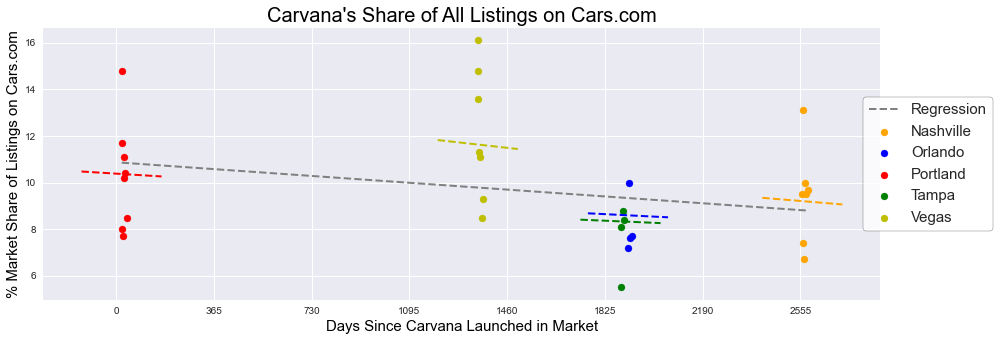

In [73]:
# Plot: 
df = timeline_carvana_market_share.drop(columns='Average')
color_dict = {'Vegas': u'y', 'Nashville': 'orange', 'Portland': u'r', 'Tampa': u'g', 'Orlando': u'b'}

groups_dict = multi_level_result.random_effects
params_series = multi_level_result.params

b_dict = {}
m_dict = {}
for group in groups_dict.keys():
    b_dict[group] = groups_dict[group]['Group'] + params_series.iloc[0]
    m_dict[group] = groups_dict[group]['Days_Since_Launch'] + params_series.iloc[1]


fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.scatter(x=df.index, y=df[column], color=color_dict[column], label=column);  # linewidth=2
    X = np.arange(df[column].dropna().index.min()-150, df[column].dropna().index.min()+150, 1)
    y = b_dict[column] + (m_dict[column] * X) 
    ax.plot(X, y, color=color_dict[column], linewidth=2, linestyle='--')

_y = [(params_series.iloc[0] + (params_series.iloc[1] * x)) for x in df.index.to_list()]
ax.plot(df.index, _y, color='grey', linewidth=2, linestyle='--', label='Regression')
ax.set_ylabel('% Market Share of Listings on Cars.com', color=u'k', fontsize=15)
ax.set_xlabel('Days Since Carvana Launched in Market', color=u'k', fontsize=15)
ax.set_title(f'Carvana\'s Share of All Listings on Cars.com', color=u'k', fontsize=20)
plt.xticks(np.arange(0, np.ceil(df.index.max() / 356) * 365, 365))
legend = plt.legend( bbox_to_anchor=(0.97,0.5), loc="center left", fontsize=15, frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor(u'k')

plt.savefig(home_folder / 'Figures' / "Figure_Dealer_Share_Cars_Carvana_AllMkts_Since_Launch.png")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2639: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


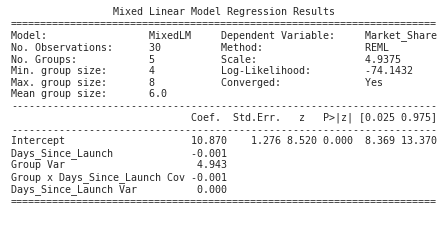

In [74]:
# Save Output: 
fig, ax = plt.subplots(figsize=(6.5, 3.5));
plt.text(0.01, 0.05, str(multi_level_result.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(home_folder / 'Figures' / "Regression_Dealer_Share_Cars_Carvana_AllMkts_Since_Launch.png")
plt.show()

In [75]:
# TrueCar Analysis:
# How much advertising of inventory overlaps between Cars.com and TrueCar?
# Is this changing over time? 

dealer_true_car_timeline_df = pd.read_csv(home_folder / 'Car_Inventory_Data' / f'Dealerships_TrueCar_Timeline.csv',
                                         index_col=[0, 1,2,3])
dealer_true_car_timeline_df = dealer_true_car_timeline_df.droplevel(0, axis=0)


In [127]:
# dealer_true_car_timeline_df

In [77]:
# TrueCar VIN overlap with Cars.com: (Select Dealers)

percent_dealer_true_car_timeline_df = dealer_true_car_timeline_df.T
for dealer in dealer_true_car_timeline_df.index.get_level_values('Dealership').unique():
    subset_df = dealer_true_car_timeline_df.loc[idx[dealer, :, :], :]
    for city in subset_df.index.get_level_values('City').unique():
        # _df = percent_dealer_true_car_timeline_df.loc[idx[dealer, city, :], :]
        index = pd.MultiIndex.from_tuples([(dealer, city, 'TrueCar_Percent_Overlap')], 
                                          names=['Dealership','City','TrueCar'])
        try:
            _percent = (pd.DataFrame(100 * dealer_true_car_timeline_df.loc[idx[dealer, city, 1], :]
                                           / dealer_true_car_timeline_df.loc[idx[dealer, city, :], :].sum(axis=0), 
                                     columns=index))
        except:
            _percent = pd.DataFrame(np.zeros(len(dealer_true_car_timeline_df.columns)), 
                                    columns=index, index=dealer_true_car_timeline_df.columns)
        percent_dealer_true_car_timeline_df = (percent_dealer_true_car_timeline_df.join(_percent))
percent_dealer_true_car_timeline_df = (percent_dealer_true_car_timeline_df.loc[:, idx[:, :, 'TrueCar_Percent_Overlap']]
                                       .apply(lambda x: round(x, 1)).T)
percent_dealer_true_car_timeline_df.columns.name = 'Date'


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 55.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


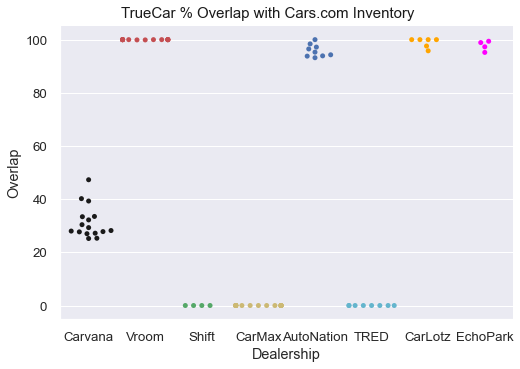

In [79]:
df = (percent_dealer_true_car_timeline_df.droplevel(level=2)
      .unstack().unstack().to_frame().reset_index().rename(columns={0: 'Overlap'}))

color_dict = {'Carvana': u'k', 'Vroom': u'r', 'Shift': u'g', 'CarMax': u'y', 'AutoNation': u'b', 
              'TRED': u'c', 'CarLotz': 'orange', 'EchoPark': 'magenta'}

sns.set(font_scale=1.2) 
f = sns.catplot(data=df, x='Dealership', y='Overlap', 
                palette=color_dict, kind="swarm", 
                order=['Carvana', 'Vroom', 'Shift', 'CarMax', 'AutoNation', 'TRED', 'CarLotz', 'EchoPark']);

f.fig.set_size_inches(8, 5)
f.fig.subplots_adjust(top=0.925)
f.fig.suptitle('TrueCar % Overlap with Cars.com Inventory', color=u'k', fontsize=15)
plt.savefig(home_folder / 'Figures' / "Figure_TrueCar_Cars_Overlap_Select_Dealers.png")
plt.show()


In [80]:
percent_dealer_true_car_timeline_df.mean(level=0).apply(lambda x: round(x, 1))

Date,2021-06-02 00:00:00,2021-06-04 00:00:00,2021-06-09 00:00:00,2021-06-14 00:00:00
Dealership,,,,
CarMax,0.0,0.0,0.0,0.0
Carvana,28.2,38.1,27.8,28.8
Shift,0.0,0.0,0.0,0.0
TRED,0.0,0.0,0.0,0.0
Vroom,100.0,100.0,100.0,100.0
AutoNation,NaN,96.8,93.8,97.0
CarLotz,NaN,100.0,98.8,97.9
EchoPark,NaN,NaN,98.1,97.3


In [81]:
percent_dealer_true_car_timeline_df.mean(level=1).apply(lambda x: round(x, 1))

Date,2021-06-02 00:00:00,2021-06-04 00:00:00,2021-06-09 00:00:00,2021-06-14 00:00:00
City,,,,
Portland,25.6,26.1,25.6,25.5
Nashville,0.0,58.4,64.5,64.4
Orlando,0.0,59.2,55.4,55.8
Tampa,0.0,55.5,60.5,60.7
Vegas,0.0,61.8,54.6,56.9


In [128]:
# Retail Dealerships Advertising Timeline:
dealership_advertising_timelines_dict = {'Vegas':'Dealership_Advertising_Timeline_Vegas.csv',
                                         'Nashville': 'Dealership_Advertising_Timeline_Nashville.csv',
                                         'Orlando': 'Dealership_Advertising_Timeline_Orlando.csv',
                                         'Tampa': 'Dealership_Advertising_Timeline_Tampa.csv',
                                        'Portland': 'Dealership_Advertising_Timeline_Portland.csv'}
# 'Dealership_Advertising_Timeline_Oregon.csv'
dealership_advertising_timeline_all_df = pd.DataFrame()

for mkt in dealership_advertising_timelines_dict.keys():
    _df = pd.read_csv(home_folder / 'Car_Inventory_Data' / dealership_advertising_timelines_dict[mkt], 
                      index_col=0)
    _df['City'] = mkt
    dealership_advertising_timeline_all_df = dealership_advertising_timeline_all_df.append(_df)


In [129]:
# dealership_advertising_timeline_all_df.set_index(['City', 'Dealership', 'Advertising']).T.sort_index()

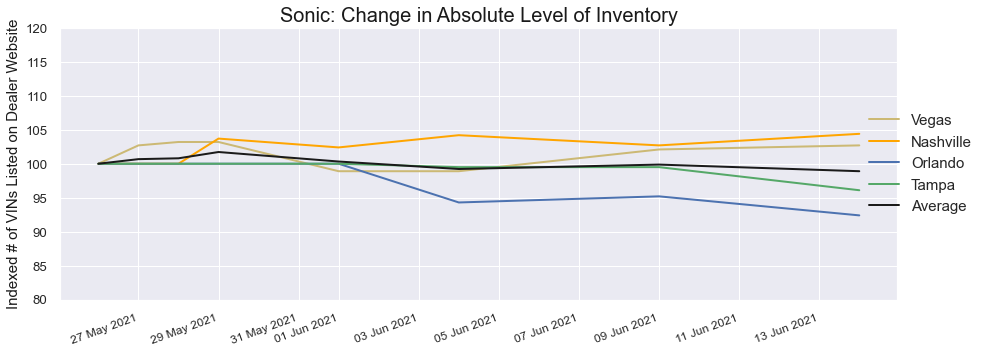

In [130]:
# Plot: Traditional Dealer Inventory Level Change

dealer = 'Sonic'
inventory_level_change_df = (dealership_advertising_timeline_all_df
                             .set_index(['City', 'Dealership', 'Advertising'])
                             .T.sort_index()
                             .loc[:, idx[:, dealer, 'Total']]
                             .droplevel(['Dealership', 'Advertising'], axis=1)
                             .ffill().bfill())
normalized_inventory_level_change_df = pd.DataFrame(index=inventory_level_change_df.index)
for column in inventory_level_change_df.columns:
        normalized_inventory_level_change_df[column] = (inventory_level_change_df[column]
                                               .div(inventory_level_change_df[column].iloc[0])
                                               .apply(lambda x: round(x * 100,1)))
normalized_inventory_level_change_df['Average'] = normalized_inventory_level_change_df.mean(axis=1)

df = normalized_inventory_level_change_df
df.index = pd.to_datetime(df.index)
color_dict = {'Vegas': u'y', 'Nashville': 'orange', 'Portland': u'r', 'Tampa': u'g', 'Orlando': u'b', 'Average': u'k'}

fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.plot(df[column], color=color_dict[column], label=column, linewidth=2);
ax.set_ylabel(f'Indexed # of VINs Listed on Dealer Website', color=u'k', fontsize=15)
ax.set_ylim(80,120)
ax.set_title(f'{dealer}: Change in Absolute Level of Inventory', color=u'k', fontsize=20)
plt.legend(bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Traditional_Dealer_Inventory_Level_Sonic.png")
plt.show()


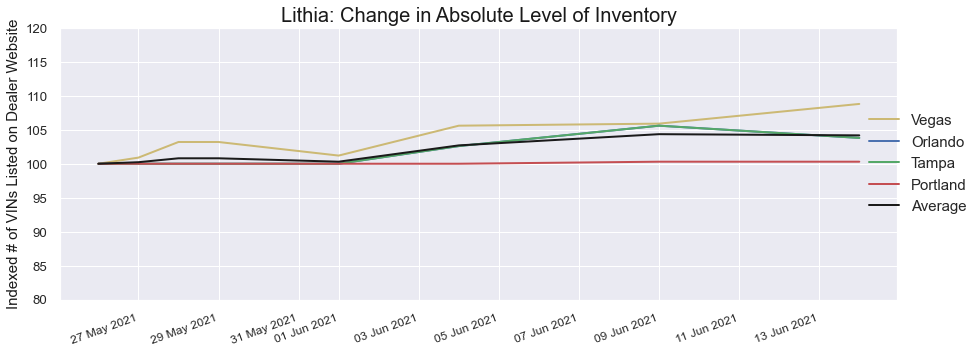

In [131]:
# Plot: Traditional Dealer Inventory Level Change

dealer = 'Lithia'  
inventory_level_change_df = (dealership_advertising_timeline_all_df
                             .set_index(['City', 'Dealership', 'Advertising'])
                             .T.sort_index()
                             .loc[:, idx[:, dealer, 'Total']]
                             .droplevel(['Dealership', 'Advertising'], axis=1)
                             .ffill().bfill())
normalized_inventory_level_change_df = pd.DataFrame(index=inventory_level_change_df.index)
for column in inventory_level_change_df.columns:
        normalized_inventory_level_change_df[column] = (inventory_level_change_df[column]
                                               .div(inventory_level_change_df[column].iloc[0])
                                               .apply(lambda x: round(x * 100,1)))
normalized_inventory_level_change_df['Average'] = normalized_inventory_level_change_df.mean(axis=1)

df = normalized_inventory_level_change_df
df.index = pd.to_datetime(df.index)
color_dict = {'Vegas': u'y', 'Nashville': 'orange', 'Portland': u'r', 'Tampa': u'g', 'Orlando': u'b', 'Average': u'k'}

fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.plot(df[column], color=color_dict[column], label=column, linewidth=2);
ax.set_ylabel(f'Indexed # of VINs Listed on Dealer Website', color=u'k', fontsize=15)
ax.set_ylim(80,120)
ax.set_title(f'{dealer}: Change in Absolute Level of Inventory', color=u'k', fontsize=20)
plt.legend(bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Traditional_Dealer_Inventory_Level_Lithia.png")
plt.show()


In [132]:
# Convert to % of Total Invetory:

percent_dealership_advertising_timeline_all_df = dealership_advertising_timeline_all_df.set_index(['City', 'Dealership', 'Advertising']).T.sort_index()
for city in percent_dealership_advertising_timeline_all_df.columns.get_level_values('City').unique():
    for dealer in percent_dealership_advertising_timeline_all_df.columns.get_level_values('Dealership').unique():
        try: 
            df = percent_dealership_advertising_timeline_all_df.loc[:, idx[city, dealer, :]]
            df = df.div(percent_dealership_advertising_timeline_all_df.loc[:, idx[city, dealer, 'Total']], axis=0).apply(lambda x: round(x*100, 1))
            percent_dealership_advertising_timeline_all_df.loc[:, idx[city, dealer, :]] = df
        except:  # example: Lithia isn't in Nashville
            pass

percent_dealership_advertising_timeline_all_df = percent_dealership_advertising_timeline_all_df.drop('Total', level=2, axis=1)
percent_dealership_advertising_timeline_all_df.index = pd.to_datetime(percent_dealership_advertising_timeline_all_df.index)


In [133]:
percent_dealership_advertising_timeline_all_df

City               Vegas                                 Nashville          \
Dealership         Sonic               Lithia                Sonic           
Advertising Cars_dot_com TrueCar Cars_dot_com TrueCar Cars_dot_com TrueCar   
2021-05-26          48.9     0.0          4.6    63.4         53.2    19.5   
2021-05-27          48.2     0.0          1.8    64.9          NaN     NaN   
2021-05-28          46.4     0.0          2.0    55.5          NaN     NaN   
2021-05-29           NaN     NaN          NaN     NaN         54.2    21.0   
2021-06-01          65.1     0.0          2.9    72.6         52.5    21.1   
2021-06-04          62.4     0.0         11.8    73.1         50.5    20.9   
2021-06-09          58.9     0.5         12.7    73.8         47.1    22.7   
2021-06-14          65.3     1.0         13.4    77.2         50.9    22.9   

City             Orlando                                     Tampa          \
Dealership         Sonic               Lithia                Sonic           
Advertising Cars_dot_com TrueCar Cars_dot_com TrueCar Cars_dot_com TrueCar   
2021-05-26           NaN     NaN          NaN     NaN          NaN     NaN   
2021-05-27           NaN     NaN          NaN     NaN          NaN     NaN   
2021-05-28           NaN     NaN          NaN     NaN          NaN     NaN   
2021-05-29           NaN     NaN          NaN     NaN          NaN     NaN   
2021-06-01          11.4     0.0          9.3    77.5          0.0     0.0   
2021-06-04          19.2     0.0         10.3    76.1          0.0     0.0   
2021-06-09          27.0     0.0         10.7    78.0          0.0     0.0   
2021-06-14          15.5     0.0         13.3    77.6          0.0     0.0   

City                                 Portland          
Dealership        Lithia               Lithia          
Advertising Cars_dot_com TrueCar Cars_dot_com TrueCar  
2021-05-26           NaN     NaN          NaN     NaN  
2021-05-27           NaN     NaN          NaN     NaN  
2021-05-28           NaN     NaN          NaN     NaN  
2021-05-29           NaN     NaN          NaN     NaN  
2021-06-01           9.3    77.5          NaN     NaN  
2021-06-04          10.3    76.1         11.6    38.0  
2021-06-09          10.7    78.0         12.3    41.0  
2021-06-14          13.3    77.6         10.6    41.5

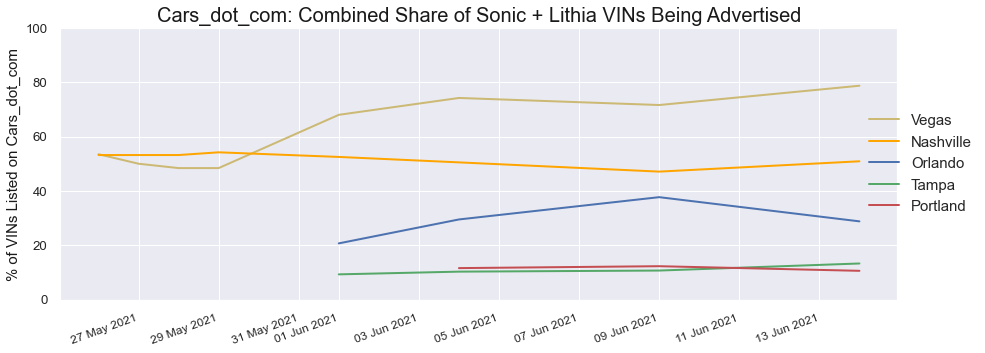

In [134]:
# Plot: 
marketplace = 'Cars_dot_com'
df = (percent_dealership_advertising_timeline_all_df.loc[:, idx[:, :, marketplace]]
      .droplevel(2, axis=1).ffill().sum(level=0, axis=1).replace(0,np.nan).sort_index()) 
df.index = pd.to_datetime(df.index)
color_dict = {'Vegas': u'y', 'Nashville': 'orange', 'Portland': u'r', 'Tampa': u'g', 'Orlando': u'b'}
fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.plot(df[column], color=color_dict[column], label=column, linewidth=2);
ax.set_ylabel(f'% of VINs Listed on {marketplace}', color=u'k', fontsize=15)
ax.set_ylim(0,100)
ax.set_title(f'{marketplace}: Combined Share of Sonic + Lithia VINs Being Advertised', color=u'k', fontsize=20)
plt.legend(bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Advertising_Share_Cars_AllMkts.png")
plt.show()


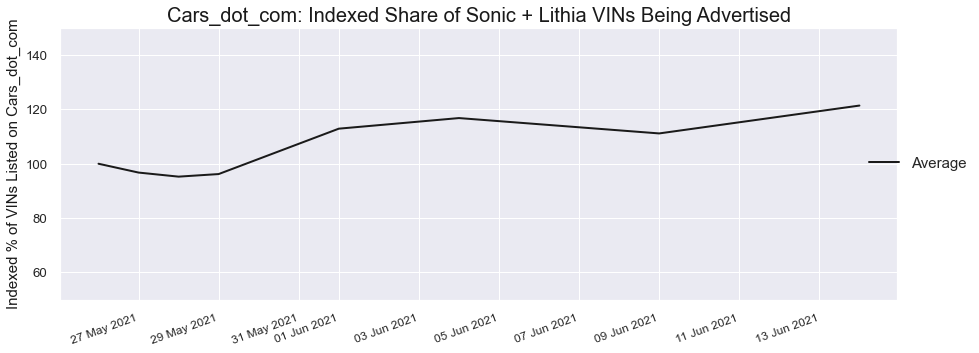

In [135]:
normalized_inventory_level_change_df = pd.DataFrame(index=df.index)
for column in df.columns:
        normalized_inventory_level_change_df[column] = (df[column].bfill()
                                               .div(df[column].iloc[0])
                                               .apply(lambda x: round(x * 100,1)))
normalized_inventory_level_change_df['Average'] = normalized_inventory_level_change_df.mean(axis=1)
normalized_inventory_level_change_df.index = pd.to_datetime(normalized_inventory_level_change_df.index)
fig, ax = plt.subplots(figsize=(15, 5));

ax.plot(normalized_inventory_level_change_df['Average'], color=u'k', label='Average', linewidth=2);
ax.set_ylabel(f'Indexed % of VINs Listed on {marketplace}', color=u'k', fontsize=15)
ax.set_ylim(50,150)
ax.set_title(f'{marketplace}: Indexed Share of Sonic + Lithia VINs Being Advertised', color=u'k', fontsize=20)
plt.legend(bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Advertising_Share_Cars_Index.png")
plt.show()

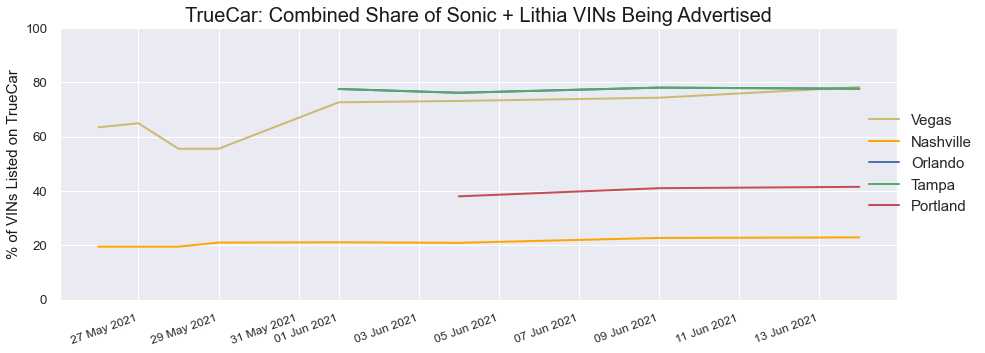

In [136]:
# Plot: 
marketplace = 'TrueCar'
df = (percent_dealership_advertising_timeline_all_df.loc[:, idx[:, :, marketplace]]
      .droplevel(2, axis=1).ffill().sum(level=0, axis=1).replace(0,np.nan).sort_index()) 
df.index = pd.to_datetime(df.index)
color_dict = {'Vegas': u'y', 'Nashville': 'orange', 'Portland': u'r', 'Tampa': u'g', 'Orlando': u'b'}
fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.plot(df[column], color=color_dict[column], label=column, linewidth=2);
ax.set_ylabel(f'% of VINs Listed on {marketplace}', color=u'k', fontsize=15)
ax.set_ylim(0,100)
ax.set_title(f'{marketplace}: Combined Share of Sonic + Lithia VINs Being Advertised', color=u'k', fontsize=20)
plt.legend(bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Advertising_Share_TrueCar_AllMkts.png")
plt.show()


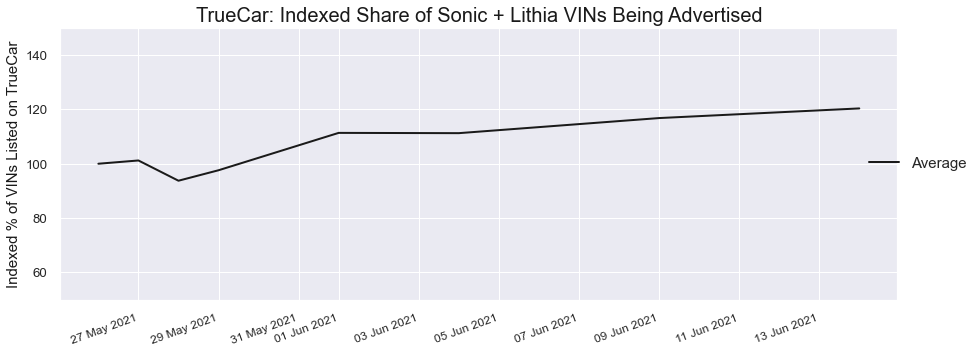

In [137]:
normalized_inventory_level_change_df = pd.DataFrame(index=df.index)
for column in df.columns:
        normalized_inventory_level_change_df[column] = (df[column].bfill()
                                               .div(df[column].iloc[0])
                                               .apply(lambda x: round(x * 100,1)))
normalized_inventory_level_change_df['Average'] = normalized_inventory_level_change_df.mean(axis=1)
normalized_inventory_level_change_df.index = pd.to_datetime(normalized_inventory_level_change_df.index)
fig, ax = plt.subplots(figsize=(15, 5));

ax.plot(normalized_inventory_level_change_df['Average'], color=u'k', label='Average', linewidth=2);
ax.set_ylabel(f'Indexed % of VINs Listed on {marketplace}', color=u'k', fontsize=15)
ax.set_ylim(50,150)
ax.set_title(f'{marketplace}: Indexed Share of Sonic + Lithia VINs Being Advertised', color=u'k', fontsize=20)
plt.legend(bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Advertising_Share_TrueCar_Index.png")
plt.show()

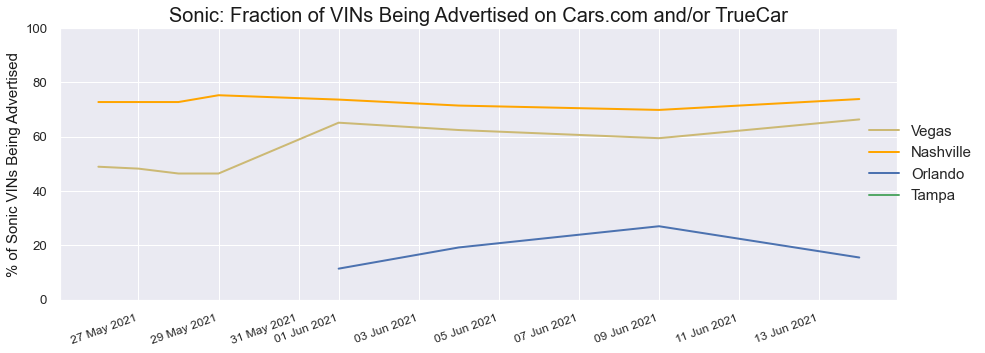

In [138]:
# Plot: 
dealer = 'Sonic'
df = (percent_dealership_advertising_timeline_all_df.loc[:, idx[:, dealer, :]]
      .droplevel(1, axis=1).ffill().sum(level=0, axis=1).replace(0,np.nan).sort_index())
df.index = pd.to_datetime(df.index)
color_dict = {'Vegas': u'y', 'Nashville': 'orange', 'Portland': u'r', 'Tampa': u'g', 'Orlando': u'b'}
fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.plot(df[column], color=color_dict[column], label=column, linewidth=2);
ax.set_ylabel(f'% of {dealer} VINs Being Advertised', color=u'k', fontsize=15)
ax.set_ylim(0,100)
ax.set_title(f'{dealer}: Fraction of VINs Being Advertised on Cars.com and/or TrueCar', color=u'k', fontsize=20)
#plt.xticks(np.arange(0, np.ceil(df.index.max() / 356) * 365, 365))
plt.legend(bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Advertising_Intensity_Sonic_AllMkts.png")
plt.show()


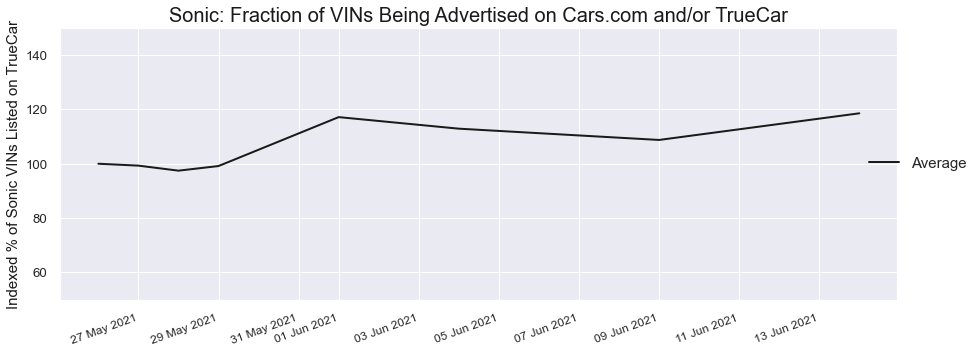

In [139]:
normalized_inventory_level_change_df = pd.DataFrame(index=df.index)
for column in df.columns:
        normalized_inventory_level_change_df[column] = (df[column].bfill()
                                               .div(df[column].iloc[0])
                                               .apply(lambda x: round(x * 100,1)))
normalized_inventory_level_change_df['Average'] = normalized_inventory_level_change_df.mean(axis=1)
normalized_inventory_level_change_df.index = pd.to_datetime(normalized_inventory_level_change_df.index)
fig, ax = plt.subplots(figsize=(15, 5));

ax.plot(normalized_inventory_level_change_df['Average'], color=u'k', label='Average', linewidth=2);
ax.set_ylabel(f'Indexed % of {dealer} VINs Listed on {marketplace}', color=u'k', fontsize=15)
ax.set_ylim(50,150)
ax.set_title(f'{dealer}: Fraction of VINs Being Advertised on Cars.com and/or TrueCar', color=u'k', fontsize=20)
plt.legend(bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Advertising_Share_Sonic_Index.png")
plt.show()

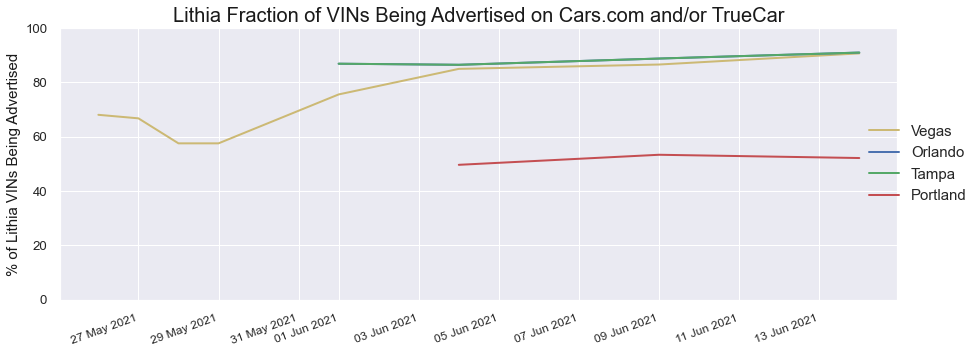

In [140]:
# Plot: 
dealer = 'Lithia'
df = (percent_dealership_advertising_timeline_all_df.loc[:, idx[:, dealer, :]]
      .droplevel(1, axis=1).ffill().sum(level=0, axis=1).replace(0,np.nan).sort_index())
df.index = pd.to_datetime(df.index)
color_dict = {'Vegas': u'y', 'Nashville': 'orange', 'Portland': u'r', 'Tampa': u'g', 'Orlando': u'b'}
fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.plot(df[column], color=color_dict[column], label=column, linewidth=2);
ax.set_ylabel(f'% of {dealer} VINs Being Advertised', color=u'k', fontsize=15)
ax.set_ylim(0,100)
ax.set_title(f'{dealer} Fraction of VINs Being Advertised on Cars.com and/or TrueCar', color=u'k', fontsize=20)
#plt.xticks(np.arange(0, np.ceil(df.index.max() / 356) * 365, 365))
plt.legend(bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Advertising_Intensity_Lithia_AllMkts.png")
plt.show()

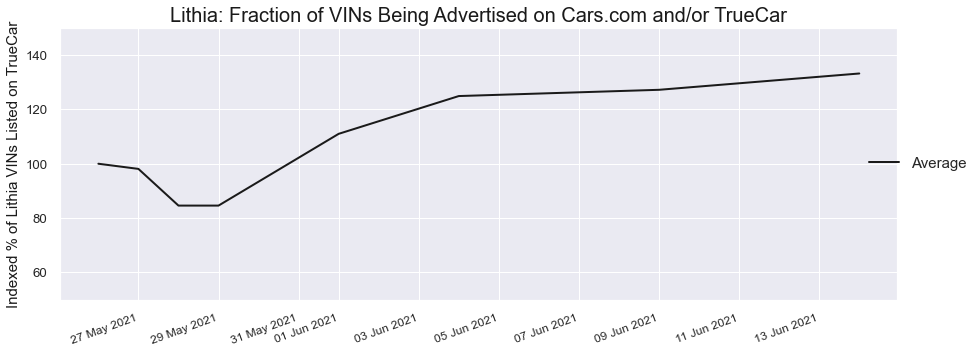

In [141]:
normalized_inventory_level_change_df = pd.DataFrame(index=df.index)
for column in df.columns:
        normalized_inventory_level_change_df[column] = (df[column].bfill()
                                               .div(df[column].iloc[0])
                                               .apply(lambda x: round(x * 100,1)))
normalized_inventory_level_change_df['Average'] = normalized_inventory_level_change_df.mean(axis=1)
normalized_inventory_level_change_df.index = pd.to_datetime(normalized_inventory_level_change_df.index)
fig, ax = plt.subplots(figsize=(15, 5));

ax.plot(normalized_inventory_level_change_df['Average'], color=u'k', label='Average', linewidth=2);
ax.set_ylabel(f'Indexed % of {dealer} VINs Listed on {marketplace}', color=u'k', fontsize=15)
ax.set_ylim(50,150)
ax.set_title(f'{dealer}: Fraction of VINs Being Advertised on Cars.com and/or TrueCar', color=u'k', fontsize=20)
plt.legend(bbox_to_anchor=(0.95,0.5), loc="center left", fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12)

plt.savefig(home_folder / 'Figures' / "Figure_Advertising_Share_Lithia_Index.png")
plt.show()

In [148]:
# Carvana Time:

# Now same charts in 'Carvana Time':
# Combined Share of VINs Being Advertised on Cars.com &/or TrueCar: For Sonic and Lithia

dealer = 'Lithia'
df = (percent_dealership_advertising_timeline_all_df.loc[:, idx[:, dealer, :]]
      .droplevel(1, axis=1).ffill().sum(level=0, axis=1).replace(0,np.nan).sort_index())
df = df.unstack().to_frame().reset_index()
df = df.rename(columns={'level_1': 'Date', 0: 'Market_Share'})
df['Date'] = pd.to_datetime(df['Date'])

advertising_intensity_carvana_timeline_df = pd.DataFrame()
for mkt in df['City'].unique():
    index_df = build_index(market_launch_dict, mkt)
    index_df = index_df.join(df[df['City'] == mkt].set_index('Date'), 
                              how='left').reset_index().set_index('Days_Since_Launch')
    advertising_intensity_carvana_timeline_df = (advertising_intensity_carvana_timeline_df
                                                 .append(index_df, ignore_index=False))
advertising_intensity_carvana_timeline_df = (advertising_intensity_carvana_timeline_df
                                             .sort_index(ascending=True)
                                             .drop(columns='Date')
                                             .dropna().reset_index()
                                             .pivot(index='Days_Since_Launch', columns='City', 
                                                    values='Market_Share')) 
advertising_intensity_carvana_timeline_df['Average'] = advertising_intensity_carvana_timeline_df.mean(axis=1)


In [149]:
# Mult-Level Regression 

# Variables:
df = (advertising_intensity_carvana_timeline_df.drop(columns='Average')
      .unstack().reset_index().rename(columns={0:'Market_Share'})
      .dropna().sort_values('Days_Since_Launch'))

# Regression: 
multi_level_sm = sm.MixedLM.from_formula("Market_Share ~ Days_Since_Launch", df, 
                                         re_formula='~Days_Since_Launch', groups=df['City'])
multi_level_result = multi_level_sm.fit()
multi_level_result.summary()


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2189: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:               MixedLM    Dependent Variable:    Market_Share
No. Observations:    19         Method:                REML        
No. Groups:          4          Scale:                 72.7101     
Min. group size:     3          Log-Likelihood:        -70.2169    
Max. group size:     8          Converged:             Yes         
Mean group size:     4.8                                           
-------------------------------------------------------------------
                              Coef.  Std.Err. z P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                     46.373                               
Days_Since_Launch              0.021                               
Group Var                     72.921                               
Group x Days_Since_Launch Cov -0.040                               
Days_Since_Launch Var          0.000                               
===================================================================

"""

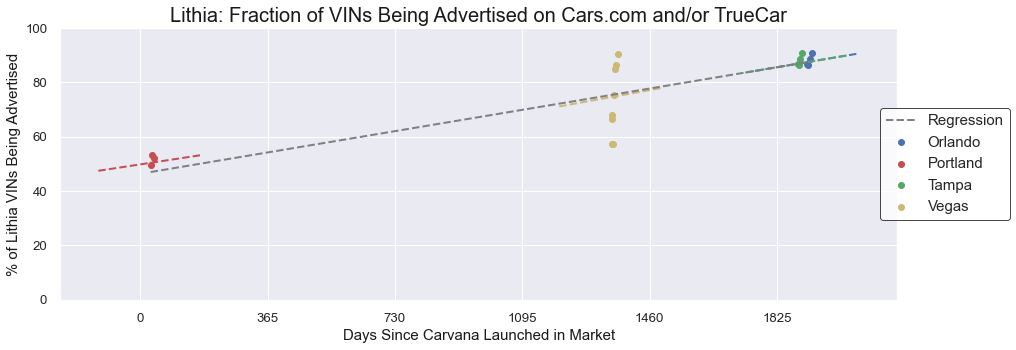

In [150]:
# Plot: 
df = advertising_intensity_carvana_timeline_df.drop(columns='Average')
color_dict = {'Vegas': u'y', 'Nashville': 'orange', 'Portland': u'r', 'Tampa': u'g', 'Orlando': u'b'}

groups_dict = multi_level_result.random_effects
params_series = multi_level_result.params

b_dict = {}
m_dict = {}
for group in groups_dict.keys():
    b_dict[group] = groups_dict[group]['Group'] + params_series.iloc[0]
    m_dict[group] = groups_dict[group]['Days_Since_Launch'] + params_series.iloc[1]

fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.scatter(x=df.index, y=df[column], color=color_dict[column], label=column);  # linewidth=2
    X = np.arange(df[column].dropna().index.min()-150, df[column].dropna().index.min()+150, 1)
    y = b_dict[column] + (m_dict[column] * X) 
    ax.plot(X, y, color=color_dict[column], linewidth=2, linestyle='--')

_y = [(params_series.iloc[0] + (params_series.iloc[1] * x)) for x in df.index.to_list()]
ax.plot(df.index, _y, color='grey', linewidth=2, linestyle='--', label='Regression')
ax.set_ylabel(f'% of {dealer} VINs Being Advertised', color=u'k', fontsize=15)
ax.set_ylim(0,100)
ax.set_title(f'{dealer}: Fraction of VINs Being Advertised on Cars.com and/or TrueCar', color=u'k', fontsize=20)
ax.set_xlabel('Days Since Carvana Launched in Market', color=u'k', fontsize=15)
plt.xticks(np.arange(0, np.ceil(df.index.max() / 356) * 365, 365))
legend = plt.legend( bbox_to_anchor=(0.97,0.5), loc="center left", fontsize=15, frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor(u'k')

plt.savefig(home_folder / 'Figures' / "Figure_CarvanaTime_Advertising_Intensity_Lithia.png")
plt.show()


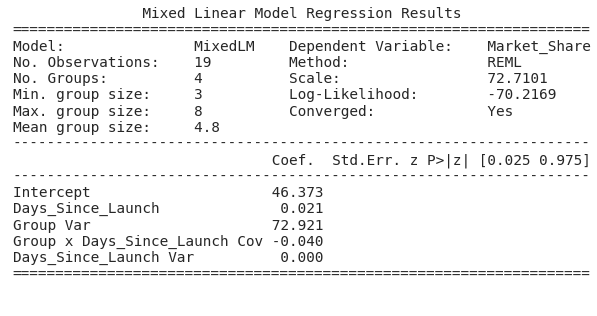

In [154]:
# Save Output: 
fig, ax = plt.subplots(figsize=(9, 5));
plt.text(0.01, 0.05, str(multi_level_result.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(home_folder / 'Figures' / "Regression_CarvanaTime_Advertising_Intensity_Lithia.png")
plt.show()

In [142]:
dealer = 'Sonic'
df = (percent_dealership_advertising_timeline_all_df.loc[:, idx[:, dealer, :]]
      .droplevel(1, axis=1).ffill().sum(level=0, axis=1).replace(0,np.nan))
df = df.unstack().to_frame().reset_index()
df = df.rename(columns={'level_1': 'Date', 0: 'Market_Share'})
df['Date'] = pd.to_datetime(df['Date'])

advertising_intensity_carvana_timeline_df = pd.DataFrame()
for mkt in df['City'].unique():
    index_df = build_index(market_launch_dict, mkt)
    index_df = index_df.join(df[df['City'] == mkt].set_index('Date'), 
                              how='left').reset_index().set_index('Days_Since_Launch')
    advertising_intensity_carvana_timeline_df = (advertising_intensity_carvana_timeline_df
                                                 .append(index_df, ignore_index=False))
advertising_intensity_carvana_timeline_df = (advertising_intensity_carvana_timeline_df
                                             .sort_index(ascending=True)
                                             .drop(columns='Date')
                                             .dropna().reset_index()
                                             .pivot(index='Days_Since_Launch', columns='City', 
                                                    values='Market_Share')) 
advertising_intensity_carvana_timeline_df['Average'] = advertising_intensity_carvana_timeline_df.mean(axis=1)


In [143]:
# Multi-Level Regression

# Variables:
df = (advertising_intensity_carvana_timeline_df.drop(columns='Average')
      .unstack().reset_index().rename(columns={0:'Market_Share'})
      .dropna().sort_values('Days_Since_Launch'))

# Regression: 
multi_level_sm = sm.MixedLM.from_formula("Market_Share ~ Days_Since_Launch", df, 
                                        groups=df['City'])  # re_formula='~Days_Since_Launch',
multi_level_result = multi_level_sm.fit()
# multi_level_result = multi_level_sm.fit_regularized(method='l1', L1_wt=1.0)  # L1_wt=1.0
# multi_level_result.fit_constrained('Market_Share')
multi_level_result.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM   Dependent Variable:   Market_Share
No. Observations:    20        Method:               REML        
No. Groups:          3         Scale:                39.0277     
Min. group size:     4         Log-Likelihood:       -70.4428    
Max. group size:     8         Converged:            Yes         
Mean group size:     6.7                                         
-----------------------------------------------------------------
                   Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------
Intercept          -15.833  103.627 -0.153 0.879 -218.937 187.271
Days_Since_Launch    0.033    0.052  0.639 0.523   -0.069   0.135
Group Var         1502.318  396.380                              
=================================================================

"""

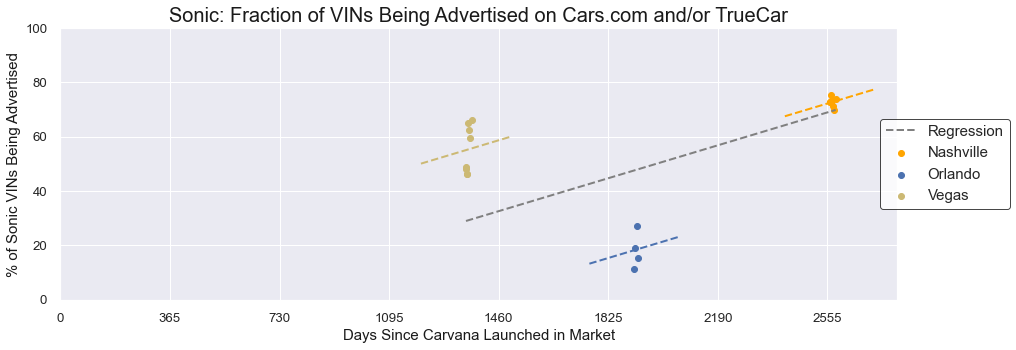

In [144]:
# UPDATED FOR NO SLOPE PARAMETERS !!!!  # (groups_dict[group]['Days_Since_Launch'] + )




# Plot: 
df = advertising_intensity_carvana_timeline_df.drop(columns='Average')
color_dict = {'Vegas': u'y', 'Nashville': 'orange', 'Portland': u'r', 'Tampa': u'g', 'Orlando': u'b'}

groups_dict = multi_level_result.random_effects
params_series = multi_level_result.params

b_dict = {}
m_dict = {}
for group in groups_dict.keys():
    b_dict[group] = groups_dict[group]['Group'] + params_series.iloc[0]
    m_dict[group] = params_series.iloc[1]  # groups_dict[group]['Days_Since_Launch'] + 

fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.scatter(x=df.index, y=df[column], color=color_dict[column], label=column);  # linewidth=2
    X = np.arange(df[column].dropna().index.min()-150, df[column].dropna().index.min()+150, 1)
    y = b_dict[column] + (m_dict[column] * X) 
    ax.plot(X, y, color=color_dict[column], linewidth=2, linestyle='--')

_y = [(params_series.iloc[0] + (params_series.iloc[1] * x)) for x in df.index.to_list()]
ax.plot(df.index, _y, color='grey', linewidth=2, linestyle='--', label='Regression')
ax.set_ylabel(f'% of {dealer} VINs Being Advertised', color=u'k', fontsize=15)
ax.set_ylim(0,100)
ax.set_title(f'{dealer}: Fraction of VINs Being Advertised on Cars.com and/or TrueCar', color=u'k', fontsize=20)
ax.set_xlabel('Days Since Carvana Launched in Market', color=u'k', fontsize=15)
plt.xticks(np.arange(0, np.ceil(df.index.max() / 356) * 365, 365))
legend = plt.legend( bbox_to_anchor=(0.97,0.5), loc="center left", fontsize=15, frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor(u'k')
plt.savefig(home_folder / 'Figures' / "Figure_CarvanaTime_Advertising_Intensity_Sonic.png")
plt.show()


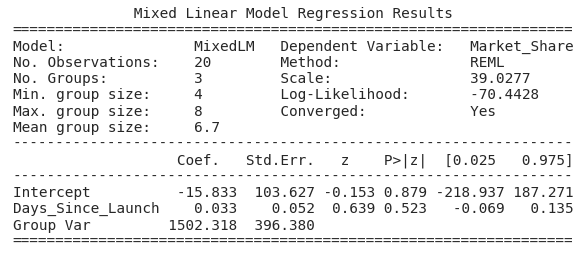

In [147]:
# Save Output: 

fig, ax = plt.subplots(figsize=(9, 4));  # figsize=(6.5, 3.5)
plt.text(0.01, 0.05, str(multi_level_result.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(home_folder / 'Figures' / "Regression_CarvanaTime_Advertising_Intensity_Sonic.png")
plt.show()

In [155]:
# Now same charts in 'Carvana Time':
# Combined Share of Sonic + Lithia VINs Being Advertised: Cars.com & TrueCar 

marketplace = 'Cars_dot_com'
df = (percent_dealership_advertising_timeline_all_df.loc[:, idx[:, :, marketplace]]
      .droplevel(2, axis=1).ffill().sum(level=0, axis=1).replace(0,np.nan))
df = df.unstack().to_frame().reset_index()
df = df.rename(columns={'level_1': 'Date', 0: 'Market_Share'})
df['Date'] = pd.to_datetime(df['Date'])

advertising_intensity_carvana_timeline_df = pd.DataFrame()
for mkt in df['City'].unique():
    index_df = build_index(market_launch_dict, mkt)
    index_df = index_df.join(df[df['City'] == mkt].set_index('Date'), 
                              how='left').reset_index().set_index('Days_Since_Launch')
    advertising_intensity_carvana_timeline_df = (advertising_intensity_carvana_timeline_df
                                                 .append(index_df, ignore_index=False))
advertising_intensity_carvana_timeline_df = (advertising_intensity_carvana_timeline_df
                                             .sort_index(ascending=True)
                                             .drop(columns='Date')
                                             .dropna().reset_index()
                                             .pivot(index='Days_Since_Launch', columns='City', 
                                                    values='Market_Share')) 
advertising_intensity_carvana_timeline_df['Average'] = advertising_intensity_carvana_timeline_df.mean(axis=1)


In [156]:
# Multi-Level Regression:

# Variables:
df = (advertising_intensity_carvana_timeline_df.drop(columns='Average')
      .unstack().reset_index().rename(columns={0:'Market_Share'})
      .dropna().sort_values('Days_Since_Launch'))

# Regression: 
multi_level_sm = sm.MixedLM.from_formula("Market_Share ~ Days_Since_Launch", df, 
                                         re_formula='Days_Since_Launch', groups=df['City'])
multi_level_result = multi_level_sm.fit()
multi_level_result.summary()


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                  MixedLM      Dependent Variable:      Market_Share
No. Observations:       27           Method:                  REML        
No. Groups:             5            Scale:                   51.8664     
Min. group size:        3            Log-Likelihood:          -107.3889   
Max. group size:        8            Converged:               No          
Mean group size:        5.4                                               
--------------------------------------------------------------------------
                              Coef.  Std.Err.   z   P>|z|  [0.025   0.975]
--------------------------------------------------------------------------
Intercept                     10.337  337.567 0.031 0.976 -651.282 671.957
Days_Since_Launch              0.017    0.171 0.097 0.923   -0.318   0.351
Group Var                     51.998 6534.431                             
Group x Days_Since_Launch Cov -0.027    7.838                             
Days_Since_Launch Var          0.014    0.007                             
==========================================================================

"""

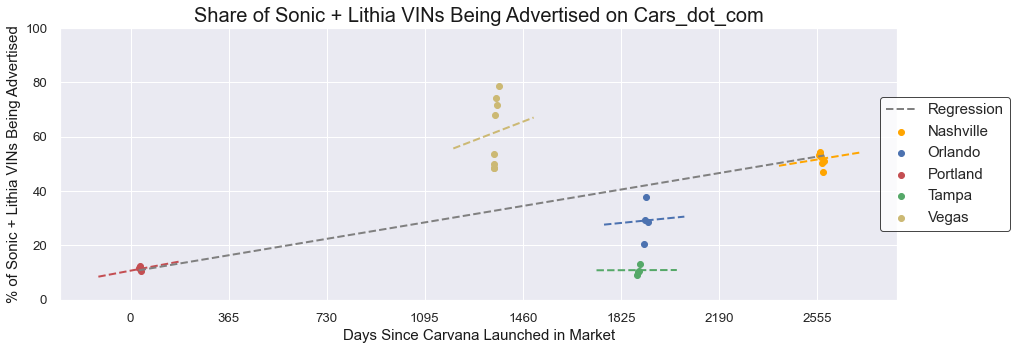

In [157]:
# Plot: 
df = advertising_intensity_carvana_timeline_df.drop(columns='Average')
color_dict = {'Vegas': u'y', 'Nashville': 'orange', 'Portland': u'r', 'Tampa': u'g', 'Orlando': u'b'}

groups_dict = multi_level_result.random_effects
params_series = multi_level_result.params

b_dict = {}
m_dict = {}
for group in groups_dict.keys():
    b_dict[group] = groups_dict[group]['Group'] + params_series.iloc[0]
    m_dict[group] = groups_dict[group]['Days_Since_Launch'] + params_series.iloc[1]

fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.scatter(x=df.index, y=df[column], color=color_dict[column], label=column);  # linewidth=2
    X = np.arange(df[column].dropna().index.min()-150, df[column].dropna().index.min()+150, 1)
    y = b_dict[column] + (m_dict[column] * X) 
    ax.plot(X, y, color=color_dict[column], linewidth=2, linestyle='--')

_y = [(params_series.iloc[0] + (params_series.iloc[1] * x)) for x in df.index.to_list()]
ax.plot(df.index, _y, color='grey', linewidth=2, linestyle='--', label='Regression')
ax.set_ylabel(f'% of Sonic + Lithia VINs Being Advertised', color=u'k', fontsize=15)
ax.set_ylim(0,100)
ax.set_title(f'Share of Sonic + Lithia VINs Being Advertised on {marketplace}', color=u'k', fontsize=20)
ax.set_xlabel('Days Since Carvana Launched in Market', color=u'k', fontsize=15)
plt.xticks(np.arange(0, np.ceil(df.index.max() / 356) * 365, 365))
legend = plt.legend( bbox_to_anchor=(0.97,0.5), loc="center left", fontsize=15, frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor(u'k')

plt.savefig(home_folder / 'Figures' / "Figure_CarvanaTime_Advertising_Intensity_Cars_dot_com.png")
plt.show()


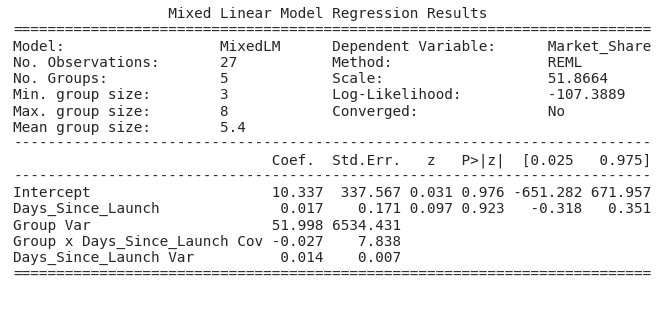

In [159]:
# Save Output: 
fig, ax = plt.subplots(figsize=(10, 5));
plt.text(0.01, 0.05, str(multi_level_result.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(home_folder / 'Figures' / "Regression_CarvanaTime_Advertising_Intensity_Cars_dot_com.png")
plt.show()

In [160]:
marketplace = 'TrueCar'
df = (percent_dealership_advertising_timeline_all_df.loc[:, idx[:, :, marketplace]]
      .droplevel(2, axis=1).ffill().sum(level=0, axis=1).replace(0,np.nan))
df = df.unstack().to_frame().reset_index()
df = df.rename(columns={'level_1': 'Date', 0: 'Market_Share'})
df['Date'] = pd.to_datetime(df['Date'])

advertising_intensity_carvana_timeline_df = pd.DataFrame()
for mkt in df['City'].unique():
    index_df = build_index(market_launch_dict, mkt)
    index_df = index_df.join(df[df['City'] == mkt].set_index('Date'), 
                              how='left').reset_index().set_index('Days_Since_Launch')
    advertising_intensity_carvana_timeline_df = (advertising_intensity_carvana_timeline_df
                                                 .append(index_df, ignore_index=False))
advertising_intensity_carvana_timeline_df = (advertising_intensity_carvana_timeline_df
                                             .sort_index(ascending=True)
                                             .drop(columns='Date')
                                             .dropna().reset_index()
                                             .pivot(index='Days_Since_Launch', columns='City', 
                                                    values='Market_Share')) 
advertising_intensity_carvana_timeline_df['Average'] = advertising_intensity_carvana_timeline_df.mean(axis=1)


In [161]:
# Multi-Level Regression:

# Variables:
df = (advertising_intensity_carvana_timeline_df.drop(columns='Average')
      .unstack().reset_index().rename(columns={0:'Market_Share'})
      .dropna().sort_values('Days_Since_Launch'))

# Regression: 
multi_level_sm = sm.MixedLM.from_formula("Market_Share ~ Days_Since_Launch", df, 
                                         re_formula='Days_Since_Launch', groups=df['City'])
multi_level_result = multi_level_sm.fit()
multi_level_result.summary()


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2639: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/Library/Frameworks/Python.framework

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:               MixedLM    Dependent Variable:    Market_Share
No. Observations:    27         Method:                REML        
No. Groups:          5          Scale:                 24.6265     
Min. group size:     3          Log-Likelihood:        -92.5239    
Max. group size:     8          Converged:             Yes         
Mean group size:     5.4                                           
-------------------------------------------------------------------
                              Coef.  Std.Err. z P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                     40.106                               
Days_Since_Launch              0.013                               
Group Var                     24.683                               
Group x Days_Since_Launch Cov -0.077                               
Days_Since_Launch Var          0.000                               
===================================================================

"""

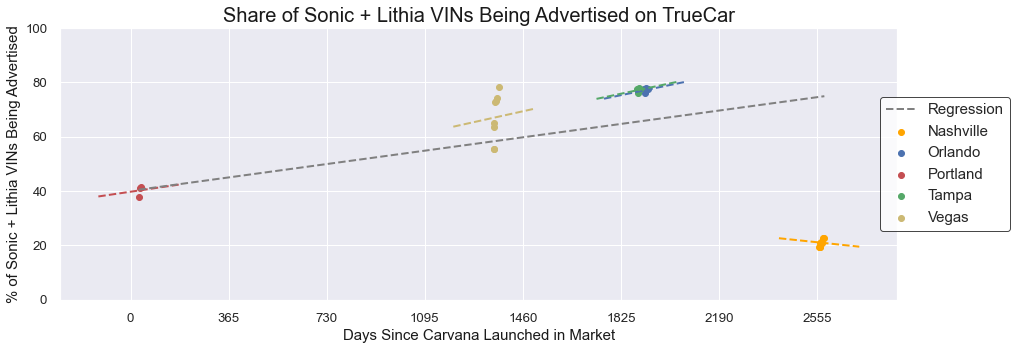

In [162]:
# Plot: 
df = advertising_intensity_carvana_timeline_df.drop(columns='Average')
color_dict = {'Vegas': u'y', 'Nashville': 'orange', 'Portland': u'r', 'Tampa': u'g', 'Orlando': u'b'}

groups_dict = multi_level_result.random_effects
params_series = multi_level_result.params

b_dict = {}
m_dict = {}
for group in groups_dict.keys():
    b_dict[group] = groups_dict[group]['Group'] + params_series.iloc[0]
    m_dict[group] = groups_dict[group]['Days_Since_Launch'] + params_series.iloc[1]

fig, ax = plt.subplots(figsize=(15, 5));
for column in df.columns:
    ax.scatter(x=df.index, y=df[column], color=color_dict[column], label=column);  # linewidth=2
    X = np.arange(df[column].dropna().index.min()-150, df[column].dropna().index.min()+150, 1)
    y = b_dict[column] + (m_dict[column] * X) 
    ax.plot(X, y, color=color_dict[column], linewidth=2, linestyle='--')

_y = [(params_series.iloc[0] + (params_series.iloc[1] * x)) for x in df.index.to_list()]
ax.plot(df.index, _y, color='grey', linewidth=2, linestyle='--', label='Regression')
ax.set_ylabel(f'% of Sonic + Lithia VINs Being Advertised', color=u'k', fontsize=15)
ax.set_ylim(0,100)
ax.set_title(f'Share of Sonic + Lithia VINs Being Advertised on {marketplace}', color=u'k', fontsize=20)
ax.set_xlabel('Days Since Carvana Launched in Market', color=u'k', fontsize=15)
plt.xticks(np.arange(0, np.ceil(df.index.max() / 356) * 365, 365))
legend = plt.legend( bbox_to_anchor=(0.97,0.5), loc="center left", fontsize=15, frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor(u'k')

plt.savefig(home_folder / 'Figures' / "Figure_CarvanaTime_Advertising_Intensity_TrueCar.png")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2639: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


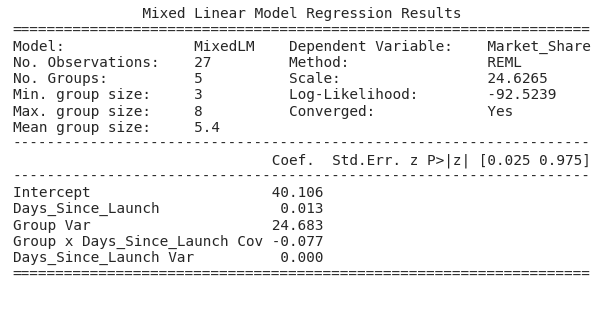

In [163]:
# Save Output: 
fig, ax = plt.subplots(figsize=(9, 5));
plt.text(0.01, 0.05, str(multi_level_result.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(home_folder / 'Figures' / "Regression_CarvanaTime_Advertising_Intensity_TrueCar.png")
plt.show()